In [1]:
import asyncio
import datetime
import sys
import os
from typing import Any, Dict, List, Literal, Optional, TypedDict

import logging
import os

# set the directory to the location of the script
try:
    os.chdir("../../../")
    target_directory = os.getenv(
        "TARGET_DIRECTORY", os.getcwd()
    )  # Use environment variable if available
    if os.path.exists(target_directory):
        os.chdir(target_directory)
        print(f"Changed directory to: {os.getcwd()}")
        logging.info(f"Successfully changed directory to: {os.getcwd()}")
    else:
        logging.error(f"Directory does not exist: {target_directory}")
except Exception as e:
    logging.exception(f"An error occurred while changing directory: {e}")

from src.cosmosdb.manager import CosmosDBMongoCoreManager
from utils.ml_logging import get_logger
from pymongo.errors import NetworkTimeout, DuplicateKeyError

logger = get_logger("auth_cosmos_migration")

Changed directory to: c:\Users\pablosal\Desktop\art-voice-agent-accelerator


## 🔍 Create the Azure AI Search Index 

**Index Purpose**: Enable hybrid search (text + semantic vector) for retail products

**Data Source**: This index receives documents from:
- ✅ This notebook (`process_single_image` function → `insert_to_azure_search`)
- ✅ **Production script**: `scripts/bulk_image_upload.py` (batch processing)

**Document Structure** (must match script payload):
```python
{
    "id": "PROD-...",              # Unique product ID (key field)
    "name": "Product Name",        # CRITICAL: For display & text search
    "category": "Bottoms",         # Enum: Tops, Bottoms, Dresses, Outerwear, Footwear, Accessories
    "gender": "Men",               # Enum: Men, Women, Unisex
    "formality": "casual",         # Enum: casual, business_casual, formal, athletic
    "fit": "slim",                 # Enum: slim, regular, relaxed, athletic
    "features": ["stretch", ...],  # Array: product features
    "climate": ["all-season"],     # Array: warm, cold, all-season
    "colors": ["blue", ...],       # Array: color tags
    "materials": ["denim", ...],   # Array: material tags
    "image_url": "https://...",    # Blob storage URL
    "rich_description": "...",     # 4-6 sentence fashion description (GPT-4o)
    "desc_vector": [3072 floats]   # Embedding for semantic search
}
```

**Search Capabilities**:
- 🔤 **Text Search**: `name`, `rich_description` (BM25 ranking)
- 🎯 **Vector Search**: `desc_vector` (semantic similarity, 3072-dim)
- 🔍 **Filters**: category, gender, formality, fit, features, climate, colors, materials
- 📊 **Facets**: All filterable fields can be used for faceted navigation


In [3]:
#!pip install azure-search-documents==11.6.0

In [2]:
import os
from azure.core.credentials import AzureKeyCredential
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SearchIndex,
    SimpleField,
    SearchField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile
)

SEARCH_ENDPOINT = os.environ["AZURE_AI_SEARCH_SERVICE_ENDPOINT"]   # e.g. https://<service>.search.windows.net
SEARCH_API_KEY  = os.environ["AZURE_AI_SEARCH_ADMIN_KEY"]  # admin key
INDEX_NAME = "clothing-index"

client = SearchIndexClient(SEARCH_ENDPOINT, AzureKeyCredential(SEARCH_API_KEY))

index = SearchIndex(
    name=INDEX_NAME,
    fields=[
        # Key field
        SimpleField(name="id", type=SearchFieldDataType.String, key=True, filterable=True),

        # CRITICAL: Product name for display (MUST be searchable for text queries)
        SearchField(name="name", type=SearchFieldDataType.String, searchable=True, filterable=True),

        # Enum fields / facets (filterable for structured queries)
        SimpleField(name="category",  type=SearchFieldDataType.String, filterable=True, facetable=True),
        SimpleField(name="gender",    type=SearchFieldDataType.String, filterable=True, facetable=True),
        SimpleField(name="formality", type=SearchFieldDataType.String, filterable=True, facetable=True),
        SimpleField(name="fit",       type=SearchFieldDataType.String, filterable=True, facetable=True),

        # Collection fields (arrays - filterable and facetable)
        SearchField(name="features",  type=SearchFieldDataType.Collection(SearchFieldDataType.String),
                    filterable=True, facetable=True),
        SearchField(name="climate",   type=SearchFieldDataType.Collection(SearchFieldDataType.String),
                    filterable=True, facetable=True),
        SearchField(name="colors",    type=SearchFieldDataType.Collection(SearchFieldDataType.String),
                    filterable=True, facetable=True),
        SearchField(name="materials", type=SearchFieldDataType.Collection(SearchFieldDataType.String),
                    filterable=True, facetable=True),

        # Image URL (not searchable, just for retrieval)
        SimpleField(name="image_url", type=SearchFieldDataType.String),

        # Text search field (rich fashion description from GPT-4o Vision)
        SearchField(name="rich_description", type=SearchFieldDataType.String, searchable=True),
        
        # Vector search field (3072-dim embedding from text-embedding-3-large)
        SearchField(
            name="desc_vector",
            type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
            searchable=True,
            vector_search_dimensions=3072,
            vector_search_profile_name="v1"
        ),
    ],
    vector_search=VectorSearch(
        algorithms=[HnswAlgorithmConfiguration(name="hnsw")],
        profiles=[VectorSearchProfile(name="v1", algorithm_configuration_name="hnsw")]
    ),
)

# Create or update idempotently
created = client.create_or_update_index(index)
print(f"✅ Index upserted: {created.name}")
print(f"📊 Total fields: {len(index.fields)}")
print(f"\n🔍 Searchable fields:")
print(f"   - name (text search)")
print(f"   - rich_description (text search)")
print(f"   - desc_vector (vector/semantic search)")
print(f"\n🎯 Filterable/Facetable fields:")
print(f"   - category, gender, formality, fit")
print(f"   - features, climate, colors, materials (arrays)")
print(f"\n💡 This index structure matches bulk_image_upload.py payload exactly!")


✅ Index upserted: clothing-index
📊 Total fields: 13

🔍 Searchable fields:
   - name (text search)
   - rich_description (text search)
   - desc_vector (vector/semantic search)
📊 Total fields: 13

🔍 Searchable fields:
   - name (text search)
   - rich_description (text search)
   - desc_vector (vector/semantic search)

🎯 Filterable/Facetable fields:
   - category, gender, formality, fit
   - features, climate, colors, materials (arrays)

💡 This index structure matches bulk_image_upload.py payload exactly!

🎯 Filterable/Facetable fields:
   - category, gender, formality, fit
   - features, climate, colors, materials (arrays)

💡 This index structure matches bulk_image_upload.py payload exactly!



## 🏗️ Database Architecture Overview

### 🎯 **Retail Database Design**
- **Database**: `retail-db` (unified retail customer experience)
- **Universal Key**: `user_id` / `product_id` (consistent across all collections)

### 📊 **Collections Structure**
1. **`users`** - Complete customer 360° profiles (demographics, preferences, shopping patterns, Dynamics 365 integration)
2. **`products`** - Product catalog with pricing, inventory, assortment, and regional variations
3. **`shopping_sessions`** - User interaction history for personalized recommendations


In [3]:
DATABASE_NAME = "retail-db"

In [4]:
# Collection Manager Factory
def get_collection_manager(collection_name: str) -> CosmosDBMongoCoreManager:
    """Get a manager for a specific collection in retail-db"""
    manager = CosmosDBMongoCoreManager(
        database_name=DATABASE_NAME,
        collection_name=collection_name
    )
    return manager

# Test database connectivity
try:
    test_manager = get_collection_manager("users")
    print(f"✅ Database Connection Successful")
    print(f"🏢 Database: {test_manager.database.name}")
    print(f"🔗 Cluster: {test_manager.cluster_host}")
except Exception as e:
    print(f"❌ Database Connection Failed: {e}")
    raise

✅ Database Connection Successful
🏢 Database: retail-db
🔗 Cluster: cosmosdb-ai-factory-westus2.mongo.cosmos.azure.com

🏢 Database: retail-db
🔗 Cluster: cosmosdb-ai-factory-westus2.mongo.cosmos.azure.com


#### 👥 Step 1: Users Collection - Complete Customer Profiles

**Purpose**: Store complete customer information for personalized shopping experiences

**Schema**:
- `_id` / `user_id`: Unique customer identifier
- `full_name`, `age`, `gender`: Demographics
- `location`: City, state, zip for regional recommendations
- `preferences`: Style, size, color preferences
- `shopping_patterns`: Purchase history, average spend, favorite categories
- `dynamics365_data`: Customer service history, loyalty points, past orders
- `conversation_memory`: Previous chat context for continuity

In [5]:
# Create sample user profiles
def create_sample_users():
    """Create diverse customer profiles for retail voice agent"""
    
    users = [
        {
            "_id": "sarah_johnson",
            "user_id": "sarah_johnson",
            "full_name": "Sarah Johnson",
            "age": 28,
            "gender": "female",
            "location": {
                "city": "Seattle",
                "state": "WA",
                "zip": "98101",
                "climate": "temperate_rainy"
            },
            "contact": {
                "email": "sarah.j@email.com",
                "phone": "+12065551234",
                "phone4": "1234"
            },
            "verification": {
                "account_last4": "5678",
                "birthdate_mmdd": "0515"
            },
            "preferences": {
                "style": ["casual", "athleisure", "minimalist"],
                "colors": ["navy", "grey", "black", "white"],
                "sizes": {"tops": "M", "bottoms": "8", "shoes": "8"},
                "brands": ["Nike", "Lululemon", "Everlane"],
                "fit_preference": "relaxed",
                "price_range": "mid"
            },
            "shopping_patterns": {
                "avg_monthly_spend": 250,
                "purchase_frequency": "bi-weekly",
                "favorite_categories": ["Activewear", "Casual Tops", "Sneakers"],
                "peak_shopping_times": ["weekend_morning", "weeknight_evening"],
                "preferred_channel": "mobile_app",
                "last_purchase_date": "2025-10-20",
                "total_lifetime_value": 4500
            },
            "dynamics365_data": {
                "customer_since": "2023-03-15",
                "loyalty_tier": "Gold",
                "loyalty_points": 3200,
                "customer_service_history": [
                    {"date": "2025-09-10", "reason": "sizing_question", "resolution": "size_guide_sent"},
                    {"date": "2025-08-05", "reason": "return_request", "resolution": "return_processed"}
                ],
                "past_orders_count": 18,
                "return_rate": 12,
                "satisfaction_score": 4.6
            },
            "conversation_memory": {
                "last_interaction": "2025-10-25",
                "recent_queries": ["yoga pants size 8", "running shoes for rain"],
                "known_context": [
                    "Training for a half marathon",
                    "Prefers sustainable brands",
                    "Usually shops during lunch breaks"
                ],
                "agent_notes": "Values quality over price, eco-conscious shopper"
            },
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        },
        {
            "_id": "michael_chen",
            "user_id": "michael_chen",
            "full_name": "Michael Chen",
            "age": 35,
            "gender": "male",
            "location": {
                "city": "San Francisco",
                "state": "CA",
                "zip": "94102",
                "climate": "mild_mediterranean"
            },
            "contact": {
                "email": "mchen@email.com",
                "phone": "+14155552345",
                "phone4": "2345"
            },
            "verification": {
                "account_last4": "9012",
                "birthdate_mmdd": "1203"
            },
            "preferences": {
                "style": ["business_casual", "modern", "tech_professional"],
                "colors": ["charcoal", "navy", "burgundy", "white"],
                "sizes": {"tops": "L", "bottoms": "34", "shoes": "10.5"},
                "brands": ["Bonobos", "J.Crew", "AllBirds"],
                "fit_preference": "slim",
                "price_range": "premium"
            },
            "shopping_patterns": {
                "avg_monthly_spend": 450,
                "purchase_frequency": "monthly",
                "favorite_categories": ["Dress Shirts", "Chinos", "Blazers"],
                "peak_shopping_times": ["sunday_afternoon"],
                "preferred_channel": "website",
                "last_purchase_date": "2025-10-22",
                "total_lifetime_value": 8900
            },
            "dynamics365_data": {
                "customer_since": "2021-06-10",
                "loyalty_tier": "Platinum",
                "loyalty_points": 7800,
                "customer_service_history": [
                    {"date": "2025-10-15", "reason": "tailoring_question", "resolution": "tailor_recommendation_provided"}
                ],
                "past_orders_count": 34,
                "return_rate": 8,
                "satisfaction_score": 4.8
            },
            "conversation_memory": {
                "last_interaction": "2025-10-22",
                "recent_queries": ["navy blazer 40R", "dress shirts no-iron"],
                "known_context": [
                    "Works in tech, needs business casual for office",
                    "Values fit and quality",
                    "Prefers online shopping with free returns"
                ],
                "agent_notes": "High-value customer, appreciates personalized service"
            },
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        },
        {
            "_id": "emma_rodriguez",
            "user_id": "emma_rodriguez",
            "full_name": "Emma Rodriguez",
            "age": 42,
            "gender": "female",
            "location": {
                "city": "Austin",
                "state": "TX",
                "zip": "78701",
                "climate": "hot_humid"
            },
            "contact": {
                "email": "emma.r@email.com",
                "phone": "+15125553456",
                "phone4": "3456"
            },
            "verification": {
                "account_last4": "3456",
                "birthdate_mmdd": "0728"
            },
            "preferences": {
                "style": ["boho", "comfortable", "colorful"],
                "colors": ["turquoise", "coral", "cream", "earth_tones"],
                "sizes": {"tops": "L", "bottoms": "12", "shoes": "9"},
                "brands": ["Free People", "Anthropologie", "Madewell"],
                "fit_preference": "relaxed",
                "price_range": "mid_premium"
            },
            "shopping_patterns": {
                "avg_monthly_spend": 320,
                "purchase_frequency": "every_3_weeks",
                "favorite_categories": ["Dresses", "Blouses", "Sandals", "Accessories"],
                "peak_shopping_times": ["thursday_evening", "saturday_afternoon"],
                "preferred_channel": "mobile_app",
                "last_purchase_date": "2025-10-18",
                "total_lifetime_value": 6200
            },
            "dynamics365_data": {
                "customer_since": "2022-01-20",
                "loyalty_tier": "Gold",
                "loyalty_points": 4900,
                "customer_service_history": [
                    {"date": "2025-09-28", "reason": "color_match_question", "resolution": "color_swatch_sent"},
                    {"date": "2025-07-15", "reason": "exchange_request", "resolution": "exchange_completed"}
                ],
                "past_orders_count": 26,
                "return_rate": 15,
                "satisfaction_score": 4.7
            },
            "conversation_memory": {
                "last_interaction": "2025-10-18",
                "recent_queries": ["flowy summer dresses", "turquoise jewelry"],
                "known_context": [
                    "Works from home, prefers comfortable clothing",
                    "Loves color and unique pieces",
                    "Often asks for styling advice"
                ],
                "agent_notes": "Creative professional, values personal expression through fashion"
            },
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        }
    ]
    
    return users

# Generate sample users
sample_users = create_sample_users()
print(f"✅ Created {len(sample_users)} sample user profiles")
for user in sample_users:
    print(f"   - {user['full_name']} ({user['age']}, {user['location']['city']}) - {user['dynamics365_data']['loyalty_tier']} member")

✅ Created 3 sample user profiles
   - Sarah Johnson (28, Seattle) - Gold member
   - Michael Chen (35, San Francisco) - Platinum member
   - Emma Rodriguez (42, Austin) - Gold member

   - Sarah Johnson (28, Seattle) - Gold member
   - Michael Chen (35, San Francisco) - Platinum member
   - Emma Rodriguez (42, Austin) - Gold member


In [6]:
# Insert users into Cosmos DB
async def insert_users():
    """Insert sample user profiles into Cosmos DB"""
    users_manager = get_collection_manager("users")
    
    try:
        for user in sample_users:
            result = await asyncio.to_thread(
                users_manager.upsert_document,
                document=user,
                query={"_id": user["_id"]}
            )
            print(f"✅ Upserted user: {user['full_name']}")
        
        print(f"\n🎉 Successfully inserted {len(sample_users)} users into Cosmos DB!")
        return True
    except Exception as e:
        print(f"❌ Failed to insert users: {e}")
        return False

# Run the insertion
await insert_users()

✅ Upserted user: Sarah Johnson

✅ Upserted user: Michael Chen
✅ Upserted user: Michael Chen
✅ Upserted user: Emma Rodriguez

🎉 Successfully inserted 3 users into Cosmos DB!
✅ Upserted user: Emma Rodriguez

🎉 Successfully inserted 3 users into Cosmos DB!


True

#### 🛍️ Step 2: Products Collection - Complete Product Catalog

**Purpose**: Store detailed product information with pricing, inventory, and assortment

**Schema**:
- `_id` / `product_id`: Matches Azure AI Search `id` field (CRITICAL for RAG pattern)
- `name`, `category`, `gender`, `brand`: Basic product info
- `pricing`: Base price, discount tiers, regional pricing variations
- `inventory`: Stock levels by region/store, availability status
- `assortment`: Which regions/stores carry this product
- `specifications`: Size, color, material, care instructions
- `merchandising`: Display priority, cross-sell recommendations

In [7]:
# Create sample products with detailed pricing and assortment
def create_sample_products():
    """Create product catalog entries matching Azure AI Search schema"""
    
    products = [
        {
            "_id": "PROD-WM-TOP-001",
            "product_id": "PROD-WM-TOP-001",  # Matches Azure AI Search id
            "name": "Classic Crew Neck T-Shirt",
            "category": "Tops",
            "gender": "Women",
            "brand": "Everlane",
            "formality": "casual",
            "fit": "relaxed",
            "features": ["breathable", "organic_cotton", "machine_washable"],
            "climate": ["warm", "mild"],
            "pricing": {
                "base_price": 28.00,
                "currency": "USD",
                "discount_tiers": {
                    "member": 25.20,  # 10% off
                    "gold": 23.80,     # 15% off
                    "platinum": 22.40  # 20% off
                },
                "regional_pricing": {
                    "US_WEST": 28.00,
                    "US_EAST": 28.00,
                    "US_SOUTH": 26.00  # Lower cost region
                },
                "sale_price": None,
                "on_sale": False
            },
            "inventory": {
                "total_stock": 450,
                "by_region": {
                    "US_WEST": {"stock": 180, "reserved": 12, "available": 168},
                    "US_EAST": {"stock": 150, "reserved": 8, "available": 142},
                    "US_SOUTH": {"stock": 120, "reserved": 5, "available": 115}
                },
                "low_stock_threshold": 50,
                "restock_date": None
            },
            "assortment": {
                "available_regions": ["US_WEST", "US_EAST", "US_SOUTH"],
                "stores": ["Seattle_Downtown", "SF_Union_Square", "Austin_Domain"],
                "online_only": False,
                "seasonal": False,
                "launch_date": "2024-01-15"
            },
            "specifications": {
                "colors": ["white", "black", "navy", "grey"],
                "sizes": ["XS", "S", "M", "L", "XL"],
                "materials": ["100% organic cotton"],
                "care_instructions": ["machine_wash_cold", "tumble_dry_low"],
                "country_of_origin": "USA"
            },
            "merchandising": {
                "display_priority": 85,
                "featured": True,
                "cross_sell": ["PROD-WM-BOTTOM-005", "PROD-WM-SHOE-012"],
                "frequently_bought_with": ["PROD-WM-BOTTOM-003"],
                "customer_rating": 4.7,
                "review_count": 342
            },
            "image_url": "https://retail-images.blob.core.windows.net/products/PROD-WM-TOP-001.jpg",
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        },
        {
            "_id": "PROD-MN-SHIRT-022",
            "product_id": "PROD-MN-SHIRT-022",
            "name": "Slim Fit Oxford Shirt",
            "category": "Shirts",
            "gender": "Men",
            "brand": "Bonobos",
            "formality": "business_casual",
            "fit": "slim",
            "features": ["wrinkle_resistant", "stretch_fabric", "machine_washable"],
            "climate": ["warm", "mild", "cold"],
            "pricing": {
                "base_price": 89.00,
                "currency": "USD",
                "discount_tiers": {
                    "member": 80.10,
                    "gold": 75.65,
                    "platinum": 71.20
                },
                "regional_pricing": {
                    "US_WEST": 89.00,
                    "US_EAST": 89.00,
                    "US_SOUTH": 85.00
                },
                "sale_price": 69.00,
                "on_sale": True
            },
            "inventory": {
                "total_stock": 280,
                "by_region": {
                    "US_WEST": {"stock": 120, "reserved": 15, "available": 105},
                    "US_EAST": {"stock": 100, "reserved": 10, "available": 90},
                    "US_SOUTH": {"stock": 60, "reserved": 3, "available": 57}
                },
                "low_stock_threshold": 40,
                "restock_date": "2025-11-15"
            },
            "assortment": {
                "available_regions": ["US_WEST", "US_EAST", "US_SOUTH"],
                "stores": ["SF_Union_Square", "Seattle_Bellevue"],
                "online_only": False,
                "seasonal": False,
                "launch_date": "2024-08-20"
            },
            "specifications": {
                "colors": ["white", "light_blue", "navy", "charcoal"],
                "sizes": ["S", "M", "L", "XL", "XXL"],
                "materials": ["97% cotton", "3% spandex"],
                "care_instructions": ["machine_wash_cold", "hang_dry"],
                "country_of_origin": "Portugal"
            },
            "merchandising": {
                "display_priority": 92,
                "featured": True,
                "cross_sell": ["PROD-MN-PANT-008", "PROD-MN-BLAZER-003"],
                "frequently_bought_with": ["PROD-MN-PANT-008"],
                "customer_rating": 4.8,
                "review_count": 521
            },
            "image_url": "https://retail-images.blob.core.windows.net/products/PROD-MN-SHIRT-022.jpg",
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        },
        {
            "_id": "PROD-WM-SHOE-045",
            "product_id": "PROD-WM-SHOE-045",
            "name": "Ultra Boost Running Shoes",
            "category": "Footwear",
            "gender": "Women",
            "brand": "Nike",
            "formality": "athletic",
            "fit": "standard",
            "features": ["cushioned", "breathable", "arch_support", "reflective"],
            "climate": ["warm", "mild", "cold", "rainy"],
            "pricing": {
                "base_price": 140.00,
                "currency": "USD",
                "discount_tiers": {
                    "member": 133.00,
                    "gold": 126.00,
                    "platinum": 119.00
                },
                "regional_pricing": {
                    "US_WEST": 140.00,
                    "US_EAST": 140.00,
                    "US_SOUTH": 135.00
                },
                "sale_price": None,
                "on_sale": False
            },
            "inventory": {
                "total_stock": 320,
                "by_region": {
                    "US_WEST": {"stock": 150, "reserved": 22, "available": 128},
                    "US_EAST": {"stock": 110, "reserved": 18, "available": 92},
                    "US_SOUTH": {"stock": 60, "reserved": 8, "available": 52}
                },
                "low_stock_threshold": 60,
                "restock_date": None
            },
            "assortment": {
                "available_regions": ["US_WEST", "US_EAST", "US_SOUTH"],
                "stores": ["Seattle_Downtown", "SF_Union_Square", "Austin_Domain"],
                "online_only": False,
                "seasonal": False,
                "launch_date": "2024-03-10"
            },
            "specifications": {
                "colors": ["black_white", "navy_coral", "grey_pink"],
                "sizes": ["6", "6.5", "7", "7.5", "8", "8.5", "9", "9.5", "10"],
                "materials": ["synthetic_mesh", "rubber_sole"],
                "care_instructions": ["spot_clean", "air_dry"],
                "country_of_origin": "Vietnam"
            },
            "merchandising": {
                "display_priority": 95,
                "featured": True,
                "cross_sell": ["PROD-WM-APPAREL-078", "PROD-WM-ACC-034"],
                "frequently_bought_with": ["PROD-WM-SOCK-012"],
                "customer_rating": 4.9,
                "review_count": 1247
            },
            "image_url": "https://retail-images.blob.core.windows.net/products/PROD-WM-SHOE-045.jpg",
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        }
    ]
    
    return products

# Generate sample products
sample_products = create_sample_products()
print(f"✅ Created {len(sample_products)} sample products")
for product in sample_products:
    price = product['pricing']['base_price']
    stock = product['inventory']['total_stock']
    print(f"   - {product['name']} (${price:.2f}) - Stock: {stock} units")

✅ Created 3 sample products
   - Classic Crew Neck T-Shirt ($28.00) - Stock: 450 units
   - Slim Fit Oxford Shirt ($89.00) - Stock: 280 units
   - Ultra Boost Running Shoes ($140.00) - Stock: 320 units

   - Classic Crew Neck T-Shirt ($28.00) - Stock: 450 units
   - Slim Fit Oxford Shirt ($89.00) - Stock: 280 units
   - Ultra Boost Running Shoes ($140.00) - Stock: 320 units


In [8]:
# Insert products into Cosmos DB
async def insert_products():
    """Insert sample products into Cosmos DB"""
    products_manager = get_collection_manager("products")
    
    try:
        for product in sample_products:
            result = await asyncio.to_thread(
                products_manager.upsert_document,
                document=product,
                query={"_id": product["_id"]}
            )
            print(f"✅ Upserted product: {product['name']}")
        
        print(f"\n🎉 Successfully inserted {len(sample_products)} products into Cosmos DB!")
        print(f"⚡ Product IDs match Azure AI Search IDs for RAG pattern")
        return True
    except Exception as e:
        print(f"❌ Failed to insert products: {e}")
        return False

# Run the insertion
await insert_products()

✅ Upserted product: Classic Crew Neck T-Shirt

✅ Upserted product: Slim Fit Oxford Shirt
✅ Upserted product: Slim Fit Oxford Shirt
✅ Upserted product: Ultra Boost Running Shoes

🎉 Successfully inserted 3 products into Cosmos DB!
⚡ Product IDs match Azure AI Search IDs for RAG pattern
✅ Upserted product: Ultra Boost Running Shoes

🎉 Successfully inserted 3 products into Cosmos DB!
⚡ Product IDs match Azure AI Search IDs for RAG pattern


True

In [9]:
# Create sample shopping sessions
def create_sample_sessions():
    """Create shopping session examples for tracking user behavior"""
    
    sessions = [
        {
            "_id": "SESSION-2025-10-25-001",
            "session_id": "SESSION-2025-10-25-001",
            "user_id": "sarah_johnson",
            "session_start": "2025-10-25T14:32:00Z",
            "session_end": "2025-10-25T14:58:00Z",
            "duration_minutes": 26,
            "products_viewed": [
                {"product_id": "PROD-WM-SHOE-045", "time_spent_seconds": 180, "timestamp": "2025-10-25T14:35:00Z"},
                {"product_id": "PROD-WM-TOP-001", "time_spent_seconds": 90, "timestamp": "2025-10-25T14:42:00Z"},
                {"product_id": "PROD-WM-APPAREL-078", "time_spent_seconds": 120, "timestamp": "2025-10-25T14:48:00Z"}
            ],
            "products_searched": [
                {"query": "running shoes for rain", "results_count": 12, "timestamp": "2025-10-25T14:33:00Z"},
                {"query": "yoga pants size 8", "results_count": 24, "timestamp": "2025-10-25T14:50:00Z"}
            ],
            "cart_items": [
                {
                    "product_id": "PROD-WM-SHOE-045",
                    "quantity": 1,
                    "size": "8",
                    "color": "navy_coral",
                    "price": 133.00,  # Member discount applied
                    "added_at": "2025-10-25T14:38:00Z"
                }
            ],
            "purchase_intent": {
                "score": 0.85,
                "signals": ["item_in_cart", "long_view_time", "member_discount_applied"],
                "predicted_conversion": True
            },
            "agent_interactions": {
                "channel": "voice",
                "query_count": 3,
                "key_questions": [
                    "Do you have running shoes good for rainy weather?",
                    "What size do you recommend for someone who usually wears 8?",
                    "Can I use my loyalty points on this purchase?"
                ],
                "recommendations_provided": ["PROD-WM-SHOE-045", "PROD-WM-APPAREL-078"],
                "satisfaction_rating": None  # Not yet completed
            },
            "context": {
                "device": "mobile",
                "location": "Seattle, WA",
                "referrer": "mobile_app_home",
                "campaign": None
            },
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        },
        {
            "_id": "SESSION-2025-10-22-045",
            "session_id": "SESSION-2025-10-22-045",
            "user_id": "michael_chen",
            "session_start": "2025-10-22T19:15:00Z",
            "session_end": "2025-10-22T19:42:00Z",
            "duration_minutes": 27,
            "products_viewed": [
                {"product_id": "PROD-MN-SHIRT-022", "time_spent_seconds": 240, "timestamp": "2025-10-22T19:18:00Z"},
                {"product_id": "PROD-MN-PANT-008", "time_spent_seconds": 150, "timestamp": "2025-10-22T19:28:00Z"},
                {"product_id": "PROD-MN-BLAZER-003", "time_spent_seconds": 180, "timestamp": "2025-10-22T19:35:00Z"}
            ],
            "products_searched": [
                {"query": "navy blazer 40R", "results_count": 8, "timestamp": "2025-10-22T19:16:00Z"},
                {"query": "dress shirts no-iron", "results_count": 15, "timestamp": "2025-10-22T19:25:00Z"}
            ],
            "cart_items": [
                {
                    "product_id": "PROD-MN-SHIRT-022",
                    "quantity": 2,
                    "size": "L",
                    "color": "white",
                    "price": 138.00,  # 2 x $69 sale price
                    "added_at": "2025-10-22T19:22:00Z"
                },
                {
                    "product_id": "PROD-MN-SHIRT-022",
                    "quantity": 1,
                    "size": "L",
                    "color": "light_blue",
                    "price": 69.00,
                    "added_at": "2025-10-22T19:23:00Z"
                }
            ],
            "purchase_intent": {
                "score": 0.92,
                "signals": ["multiple_items_in_cart", "sale_price", "high_value_customer", "repeat_buyer"],
                "predicted_conversion": True
            },
            "agent_interactions": {
                "channel": "chat",
                "query_count": 5,
                "key_questions": [
                    "Is the slim fit shirt true to size?",
                    "Can I get free returns if these don't fit?",
                    "Do you have matching pants for business casual?",
                    "What's your fastest shipping option?",
                    "Can I apply my loyalty points to this order?"
                ],
                "recommendations_provided": ["PROD-MN-PANT-008", "PROD-MN-BLAZER-003"],
                "satisfaction_rating": 5  # Excellent
            },
            "context": {
                "device": "desktop",
                "location": "San Francisco, CA",
                "referrer": "google_search",
                "campaign": "fall_sale_2025"
            },
            "created_at": datetime.datetime.utcnow().isoformat() + "Z",
            "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
        }
    ]
    
    return sessions

# Generate sample sessions
sample_sessions = create_sample_sessions()
print(f"✅ Created {len(sample_sessions)} sample shopping sessions")
for session in sample_sessions:
    user = session['user_id']
    items = len(session['cart_items'])
    intent = session['purchase_intent']['score']
    print(f"   - {session['session_id']}: User {user}, {items} cart items, {intent:.0%} purchase intent")

✅ Created 2 sample shopping sessions
   - SESSION-2025-10-25-001: User sarah_johnson, 1 cart items, 85% purchase intent
   - SESSION-2025-10-22-045: User michael_chen, 2 cart items, 92% purchase intent

   - SESSION-2025-10-25-001: User sarah_johnson, 1 cart items, 85% purchase intent
   - SESSION-2025-10-22-045: User michael_chen, 2 cart items, 92% purchase intent


In [10]:
# Insert shopping sessions into Cosmos DB
async def insert_sessions():
    """Insert sample shopping sessions into Cosmos DB"""
    sessions_manager = get_collection_manager("shopping_sessions")
    
    try:
        for session in sample_sessions:
            result = await asyncio.to_thread(
                sessions_manager.upsert_document,
                document=session,
                query={"_id": session["_id"]}
            )
            print(f"✅ Upserted session: {session['session_id']}")
        
        print(f"\n🎉 Successfully inserted {len(sample_sessions)} shopping sessions into Cosmos DB!")
        return True
    except Exception as e:
        print(f"❌ Failed to insert sessions: {e}")
        return False

# Run the insertion
await insert_sessions()

✅ Upserted session: SESSION-2025-10-25-001

✅ Upserted session: SESSION-2025-10-22-045

🎉 Successfully inserted 2 shopping sessions into Cosmos DB!
✅ Upserted session: SESSION-2025-10-22-045

🎉 Successfully inserted 2 shopping sessions into Cosmos DB!


True

## 📸 Step 4: Process Images with Azure OpenAI - Index to Azure AI Search & Cosmos DB

**Pipeline Flow**:
1. Load image from `utils/data/clothes/`
2. **Azure OpenAI GPT-4o Vision**: Extract product details (category, colors, materials, style)
3. **Generate Product ID**: Unique identifier
4. **Upload to Azure Blob Storage**: Get real public URL for image retrieval
5. **Azure OpenAI Embeddings**: Generate 3072-dim vector from description
6. **Generate Realistic Data**: Pricing, inventory, assortment (using AI)
7. **Validate with Pydantic**: Schema validation
8. **Insert into Azure AI Search**: Searchable index with real image URL
9. **Insert into Cosmos DB**: Complete product details with real image URL

**Models Used**:
- Vision: `gpt-4o` for image analysis
- Embeddings: `text-embedding-3-large` (3072 dimensions)

**Storage**:
- Images: Azure Blob Storage container `retail-products`
- Search: Azure AI Search index `clothing-index`
- Data: Cosmos DB database `retail-db` collection `products`

In [11]:
# Step 1: Setup Azure OpenAI Clients
import os
import json
import base64
from pathlib import Path
from pydantic import BaseModel, Field
from typing import List, Optional, Literal
from openai import AzureOpenAI

# Azure OpenAI Configuration
AOAI_KEY = os.environ["AZURE_OPENAI_KEY"]
AOAI_ENDPOINT = os.environ["AZURE_OPENAI_ENDPOINT"]
AOAI_API_VERSION = "2024-08-01-preview"
EMBEDDING_MODEL = os.environ.get("AZURE_OPENAI_CHAT_EMBEDDING_ID", "text-embedding-3-large")
EMBEDDING_DIMENSIONS = int(os.environ.get("AZURE_OPENAI_EMBEDDING_DIMENSIONS", "3072"))
VISION_MODEL = "gpt-4o"  # For image analysis

# Initialize Azure OpenAI client
aoai_client = AzureOpenAI(
    api_key=AOAI_KEY,
    api_version=AOAI_API_VERSION,
    azure_endpoint=AOAI_ENDPOINT
)

print(f"✅ Azure OpenAI Client Initialized")
print(f"   🔍 Vision Model: {VISION_MODEL}")
print(f"   📊 Embedding Model: {EMBEDDING_MODEL} ({EMBEDDING_DIMENSIONS} dimensions)")
print(f"   🌐 Endpoint: {AOAI_ENDPOINT}")

✅ Azure OpenAI Client Initialized
   🔍 Vision Model: gpt-4o
   📊 Embedding Model: text-embedding-3-large (3072 dimensions)
   🌐 Endpoint: https://aoai-ai-factory-eus-dev.openai.azure.com/

   🔍 Vision Model: gpt-4o
   📊 Embedding Model: text-embedding-3-large (3072 dimensions)
   🌐 Endpoint: https://aoai-ai-factory-eus-dev.openai.azure.com/


In [ ]:
# Step 2: Define Pydantic Schemas for Validation with STRICT ENUMS

class ProductExtraction(BaseModel):
    """Schema for data extracted from product image - STRICT ENUMS TO PREVENT HALLUCINATIONS"""
    name: str = Field(..., description="Product name/title")
    
    # STRICT ENUMS - Only these values allowed
    category: Literal["Tops", "Bottoms", "Dresses", "Outerwear", "Footwear", "Accessories"] = Field(
        ..., description="MUST be exactly one of: Tops, Bottoms, Dresses, Outerwear, Footwear, Accessories"
    )
    gender: Literal["Men", "Women", "Unisex"] = Field(
        ..., description="MUST be exactly one of: Men, Women, Unisex"
    )
    formality: Literal["casual", "business_casual", "formal", "athletic"] = Field(
        ..., description="MUST be exactly one of: casual, business_casual, formal, athletic"
    )
    fit: Literal["slim", "regular", "relaxed", "athletic"] = Field(
        ..., description="MUST be exactly one of: slim, regular, relaxed, athletic"
    )
    
    # Color list (expanded but controlled)
    colors: List[str] = Field(
        ..., 
        description="Main colors: black, white, blue, red, green, grey, brown, pink, purple, yellow, orange, neutral"
    )
    
    # Material list (expanded but controlled)
    materials: List[str] = Field(
        ..., 
        description="Materials: cotton, denim, wool, polyester, leather, silk, linen, fleece, nylon, premium fabric"
    )
    
    # Features list
    features: List[str] = Field(
        ..., 
        description="Features: stretch, moisture-wicking, water-resistant, wrinkle-free, fade-resistant, pockets, lined, button-down, zip, comfortable, versatile, stylish"
    )
    
    # Climate with strict options
    climate: List[Literal["warm", "cold", "all-season"]] = Field(
        ..., description="Suitable climates: warm, cold, all-season"
    )
    
    # RICH DESCRIPTION - This is critical for semantic search
    rich_description: str = Field(
        ..., 
        description="DETAILED 4-6 sentence description written like a fashion magazine. Must include: style details, fabric quality, fit description, occasion suitability, seasonal recommendations, and styling suggestions. Be vivid and specific."
    )
    
    style_tags: List[str] = Field(
        ..., 
        description="Style descriptors: vintage, modern, classic, trendy, minimalist, bold, elegant, sporty, urban, timeless"
    )

class PricingData(BaseModel):
    """Pricing tiers and regional variations"""
    base_price: float
    currency: str = "USD"
    discount_tiers: dict = Field(default={"member": 0, "gold": 0, "platinum": 0})
    regional_pricing: dict = Field(default={"US_WEST": 0, "US_EAST": 0, "US_SOUTH": 0})
    sale_price: Optional[float] = None
    on_sale: bool = False

class InventoryData(BaseModel):
    """Stock levels by region"""
    total_stock: int
    by_region: dict
    low_stock_threshold: int
    restock_date: Optional[str] = None

class CompleteProduct(BaseModel):
    """Complete product for Cosmos DB"""
    product_id: str
    name: str
    category: str
    gender: str
    brand: str
    formality: str
    fit: str
    features: List[str]
    climate: List[str]
    pricing: dict
    inventory: dict
    assortment: dict
    specifications: dict
    merchandising: dict
    image_url: str
    rich_description: str
    desc_vector: List[float]
    
print("✅ Pydantic schemas defined with STRICT ENUMS for validation")

✅ Pydantic schemas defined for validation



In [ ]:
# Step 3: Image Processing with Azure OpenAI Vision - FASHION STYLIST MODE

def encode_image_to_base64(image_path: Path) -> str:
    """Encode image to base64 for Azure OpenAI"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

def analyze_product_image(image_path: Path) -> ProductExtraction:
    """Use GPT-4o Vision to extract product details from image"""
    
    # Encode image
    base64_image = encode_image_to_base64(image_path)
    
    # ENHANCED FASHION STYLIST PROMPT - Much richer descriptions
    system_prompt = """You are a professional fashion stylist and product copywriter for a high-end retail brand. 

Your expertise includes:
- Analyzing garment construction, fabric quality, and design details
- Writing compelling product descriptions that help customers visualize wearing the item
- Understanding seasonal trends, occasion appropriateness, and styling versatility
- Identifying the perfect customer for each piece

CRITICAL INSTRUCTIONS:
1. Use ONLY the exact enum values provided - no variations or synonyms
2. Write rich_description as if you're speaking to a customer looking for the perfect piece
3. Include specific fabric details, fit characteristics, and styling suggestions
4. Mention what occasions this would be perfect for
5. Describe how it feels to wear and its versatility

STRICT ENUMS - You MUST use exactly these values:
- category: "Tops" | "Bottoms" | "Dresses" | "Outerwear" | "Footwear" | "Accessories"
- gender: "Men" | "Women" | "Unisex"
- formality: "casual" | "business_casual" | "formal" | "athletic"
- fit: "slim" | "regular" | "relaxed" | "athletic"
- climate: ["warm", "cold", "all-season"] (can be multiple)

CONTROLLED VOCABULARY:
- colors: black, white, blue, red, green, grey, brown, pink, purple, yellow, orange, neutral
- materials: cotton, denim, wool, polyester, leather, silk, linen, fleece, nylon, premium fabric
- features: stretch, moisture-wicking, water-resistant, wrinkle-free, fade-resistant, pockets, lined, button-down, zip, comfortable, versatile, stylish
- style_tags: vintage, modern, classic, trendy, minimalist, bold, elegant, sporty, urban, timeless

Return JSON with this EXACT structure:
{
    "name": "Descriptive product name (e.g., 'Slim Fit Stone-Wash Denim Jeans')",
    "category": "MUST be one of: Tops, Bottoms, Dresses, Outerwear, Footwear, Accessories",
    "gender": "MUST be one of: Men, Women, Unisex",
    "formality": "MUST be one of: casual, business_casual, formal, athletic",
    "fit": "MUST be one of: slim, regular, relaxed, athletic",
    "colors": ["List main colors from the controlled vocabulary"],
    "materials": ["List perceived materials from the controlled vocabulary"],
    "features": ["List special features from the controlled vocabulary"],
    "climate": ["MUST be from: warm, cold, all-season"],
    "rich_description": "WRITE 4-6 SENTENCES as a fashion stylist. Example: 'Elevate your everyday wardrobe with these premium slim-fit jeans, expertly crafted from 98% cotton denim with just enough stretch for all-day comfort. The stone-wash finish gives them a lived-in, vintage appeal that pairs perfectly with everything from crisp white tees to tailored blazers. Designed with a modern slim fit that flatters without restricting movement, these jeans feature classic five-pocket styling and durable construction that only gets better with age. Perfect for casual Fridays at the office, weekend brunches, or evening drinks with friends. The versatile mid-blue wash transitions seamlessly from season to season, making these a true wardrobe essential. Pair with sneakers for a laid-back look or dress them up with loafers and a button-down for smart-casual occasions.'",
    "style_tags": ["2-4 style descriptors from the controlled vocabulary"]
}

REMEMBER: Write the rich_description as if you're helping a customer understand why this piece is perfect for them. Be specific, vivid, and helpful."""
    
    try:
        response = aoai_client.chat.completions.create(
            model=VISION_MODEL,
            messages=[
                {"role": "system", "content": system_prompt},
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": f"Analyze this clothing item: {image_path.name}. Write a compelling fashion description that helps customers find and fall in love with this piece. Extract all details in JSON format using ONLY the specified enum values."
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            response_format={"type": "json_object"},
            temperature=0.3,  # Keep consistent for enum adherence
            max_tokens=1500  # Increased for richer descriptions
        )
        
        # Parse response
        result = json.loads(response.choices[0].message.content)
        
        # Validate with Pydantic (will enforce strict enums)
        product_data = ProductExtraction(**result)
        
        return product_data
        
    except Exception as e:
        print(f"❌ Error analyzing image: {e}")
        raise

print("✅ Fashion Stylist image analysis function ready")

✅ Image analysis function ready



In [14]:
# Step 4: Generate Embeddings for Text Description

def generate_embedding(text: str) -> List[float]:
    """Generate 3072-dim embedding using text-embedding-3-large"""
    try:
        response = aoai_client.embeddings.create(
            model=EMBEDDING_MODEL,
            input=text,
            dimensions=EMBEDDING_DIMENSIONS
        )
        return response.data[0].embedding
    except Exception as e:
        print(f"❌ Error generating embedding: {e}")
        raise

print(f"✅ Embedding generation ready ({EMBEDDING_DIMENSIONS} dimensions)")

✅ Embedding generation ready (3072 dimensions)



In [15]:
# Step 5: Generate Realistic Product Data with AI

import random
import hashlib

def generate_product_id(image_path: Path, gender: str, category: str) -> str:
    """Generate unique product ID based on image and metadata"""
    # Create hash from filename for consistency
    hash_input = f"{image_path.name}_{gender}_{category}"
    hash_short = hashlib.md5(hash_input.encode()).hexdigest()[:8].upper()
    
    # Format: PROD-{GENDER_CODE}-{CATEGORY_CODE}-{HASH}
    gender_code = "MN" if gender == "Men" else "WM" if gender == "Women" else "UN"
    category_code = category[:4].upper()
    
    return f"PROD-{gender_code}-{category_code}-{hash_short}"

async def generate_realistic_product_data(
    product_extraction: ProductExtraction,
    product_id: str,
    image_path: Path
) -> dict:
    """Use Azure OpenAI to generate realistic pricing, inventory, and assortment data"""
    
    prompt = f"""Generate realistic retail product data for this clothing item:
    
Product: {product_extraction.name}
Category: {product_extraction.category}
Gender: {product_extraction.gender}
Materials: {', '.join(product_extraction.materials)}
Features: {', '.join(product_extraction.features)}

Generate realistic data for a mid-to-premium retail brand. Return JSON with:

{{
    "brand": "realistic brand name for this product type",
    "base_price": realistic_price_in_dollars,
    "total_stock": realistic_inventory_count,
    "sizes": ["appropriate sizes for this product"],
    "customer_rating": rating_out_of_5,
    "review_count": number_of_reviews,
    "display_priority": priority_score_0_to_100
}}

Be realistic - jeans typically $60-120, sweaters $40-90, etc."""

    try:
        response = aoai_client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a retail merchandising expert. Generate realistic product data."},
                {"role": "user", "content": prompt}
            ],
            response_format={"type": "json_object"},
            temperature=0.7,
            max_tokens=500
        )
        
        ai_data = json.loads(response.choices[0].message.content)
        
        # Calculate pricing tiers
        base_price = ai_data["base_price"]
        pricing = {
            "base_price": base_price,
            "currency": "USD",
            "discount_tiers": {
                "member": round(base_price * 0.90, 2),  # 10% off
                "gold": round(base_price * 0.85, 2),     # 15% off
                "platinum": round(base_price * 0.80, 2)  # 20% off
            },
            "regional_pricing": {
                "US_WEST": base_price,
                "US_EAST": base_price,
                "US_SOUTH": round(base_price * 0.95, 2)  # 5% cheaper
            },
            "sale_price": round(base_price * 0.75, 2) if random.random() < 0.3 else None,
            "on_sale": random.random() < 0.3
        }
        
        # Generate inventory by region
        total_stock = ai_data["total_stock"]
        west_stock = int(total_stock * 0.40)
        east_stock = int(total_stock * 0.35)
        south_stock = total_stock - west_stock - east_stock
        
        inventory = {
            "total_stock": total_stock,
            "by_region": {
                "US_WEST": {
                    "stock": west_stock,
                    "reserved": random.randint(5, 20),
                    "available": west_stock - random.randint(5, 20)
                },
                "US_EAST": {
                    "stock": east_stock,
                    "reserved": random.randint(3, 15),
                    "available": east_stock - random.randint(3, 15)
                },
                "US_SOUTH": {
                    "stock": south_stock,
                    "reserved": random.randint(2, 10),
                    "available": south_stock - random.randint(2, 10)
                }
            },
            "low_stock_threshold": int(total_stock * 0.15),
            "restock_date": None if total_stock > 100 else "2025-11-15"
        }
        
        # Assortment data
        assortment = {
            "available_regions": ["US_WEST", "US_EAST", "US_SOUTH"],
            "stores": ["Seattle_Downtown", "SF_Union_Square", "Austin_Domain"],
            "online_only": False,
            "seasonal": "Sweaters" in product_extraction.category,
            "launch_date": "2024-09-01"
        }
        
        # Specifications
        specifications = {
            "colors": product_extraction.colors,
            "sizes": ai_data["sizes"],
            "materials": product_extraction.materials,
            "care_instructions": ["machine_wash_cold", "tumble_dry_low"] if "cotton" in str(product_extraction.materials).lower() else ["dry_clean_only"],
            "country_of_origin": random.choice(["USA", "Italy", "Portugal", "Vietnam"])
        }
        
        # Merchandising
        merchandising = {
            "display_priority": ai_data["display_priority"],
            "featured": ai_data["display_priority"] > 85,
            "cross_sell": [],  # Will be populated later
            "frequently_bought_with": [],
            "customer_rating": ai_data["customer_rating"],
            "review_count": ai_data["review_count"]
        }
        
        return {
            "brand": ai_data["brand"],
            "pricing": pricing,
            "inventory": inventory,
            "assortment": assortment,
            "specifications": specifications,
            "merchandising": merchandising
        }
        
    except Exception as e:
        print(f"❌ Error generating product data: {e}")
        raise

print("✅ Realistic data generation ready")

✅ Realistic data generation ready



In [16]:
# Step 5.5: Upload Image to Azure Blob Storage (MANAGED IDENTITY)

from azure.storage.blob import BlobServiceClient, ContentSettings
from azure.identity import DefaultAzureCredential
from azure.core.exceptions import ResourceExistsError

# Azure Blob Storage Configuration (Managed Identity - NO CONNECTION STRING)
AZURE_STORAGE_ACCOUNT_NAME = os.environ.get("AZURE_STORAGE_ACCOUNT_NAME", "storagefactoryeastus")
BLOB_CONTAINER_NAME = os.environ.get("AZURE_BLOB_CONTAINER_PRODUCTS", "clothesimages")

async def upload_image_to_blob(image_path: Path, product_id: str) -> str:
    """
    Upload product image to Azure Blob Storage using MANAGED IDENTITY
    
    NOTE: This storage account has Shared Key authorization DISABLED.
    Must use Managed Identity (DefaultAzureCredential) instead of connection string.
    
    Args:
        image_path: Path to local image file
        product_id: Unique product identifier
    
    Returns:
        Public URL to the uploaded blob
    """
    try:
        # Initialize Blob Service Client with Managed Identity
        account_url = f"https://{AZURE_STORAGE_ACCOUNT_NAME}.blob.core.windows.net"
        credential = DefaultAzureCredential()
        blob_service_client = BlobServiceClient(account_url=account_url, credential=credential)
        
        print(f"   🔐 Using Managed Identity for storage account: {AZURE_STORAGE_ACCOUNT_NAME}")
        
        # Create container if it doesn't exist
        try:
            container_client = blob_service_client.create_container(BLOB_CONTAINER_NAME)
            print(f"   📦 Created container: {BLOB_CONTAINER_NAME}")
        except ResourceExistsError:
            container_client = blob_service_client.get_container_client(BLOB_CONTAINER_NAME)
        
        # Determine file extension and content type
        file_ext = image_path.suffix.lower()
        content_type_map = {
            ".jpg": "image/jpeg",
            ".jpeg": "image/jpeg",
            ".png": "image/png",
            ".webp": "image/webp"
        }
        content_type = content_type_map.get(file_ext, "image/jpeg")
        
        # Create blob name with product ID
        blob_name = f"products/{product_id}{file_ext}"
        
        # Upload image
        blob_client = blob_service_client.get_blob_client(
            container=BLOB_CONTAINER_NAME,
            blob=blob_name
        )
        
        with open(image_path, "rb") as data:
            blob_client.upload_blob(
                data,
                overwrite=True,
                content_settings=ContentSettings(content_type=content_type)
            )
        
        # Generate public URL
        blob_url = blob_client.url
        
        print(f"   ✅ Uploaded to blob: {blob_name}")
        print(f"   🌐 URL: {blob_url}")
        
        return blob_url
        
    except Exception as e:
        print(f"   ❌ Failed to upload to blob storage: {e}")
        print(f"   💡 Make sure you're logged in with 'az login' and have 'Storage Blob Data Contributor' role")
        # Return a fallback URL pattern
        fallback_url = f"https://{AZURE_STORAGE_ACCOUNT_NAME}.blob.core.windows.net/{BLOB_CONTAINER_NAME}/products/{product_id}{image_path.suffix}"
        print(f"   ⚠️  Using fallback URL: {fallback_url}")
        return fallback_url

print("✅ Blob storage upload function ready (Managed Identity)")
print(f"   Storage Account: {AZURE_STORAGE_ACCOUNT_NAME}")
print(f"   Container: {BLOB_CONTAINER_NAME}")
print(f"   🔐 Auth: Managed Identity (Shared Key disabled)")


✅ Blob storage upload function ready (Managed Identity)
   Storage Account: storagefactoryeastus
   Container: clothesimages
   🔐 Auth: Managed Identity (Shared Key disabled)

   Storage Account: storagefactoryeastus
   Container: clothesimages
   🔐 Auth: Managed Identity (Shared Key disabled)


In [ ]:
# Step 6: Complete Pipeline - Process ONE Image

async def process_single_image(image_path: Path) -> dict:
    """
    Complete pipeline: Image → Vision Analysis → Embedding → Data Generation → Index
    
    Returns: Complete product data ready for Azure AI Search + Cosmos DB
    """
    print(f"\n{'='*70}")
    print(f"🖼️  Processing: {image_path.name}")
    print(f"{'='*70}")
    
    # Step 1: Extract from folder structure
    parts = image_path.parts
    gender_folder = parts[-2]  # "men" or "woman"
    category_folder = parts[-3]  # "jeans" or "sweaters"
    
    gender_map = {"men": "Men", "woman": "Women"}
    category_map = {"jeans": "Jeans", "sweaters": "Sweaters"}
    
    detected_gender = gender_map.get(gender_folder.lower(), "Unisex")
    detected_category = category_map.get(category_folder.lower(), "Clothing")
    
    print(f"📁 Detected: {detected_category} / {detected_gender}")
    
    # Step 2: Analyze image with GPT-4o Vision
    print(f"\n1️⃣ Analyzing image with GPT-4o Vision...")
    product_extraction = analyze_product_image(image_path)
    print(f"   ✅ Extracted: {product_extraction.name}")
    print(f"   🎨 Colors: {', '.join(product_extraction.colors)}")
    print(f"   📝 Description: {product_extraction.rich_description[:100]}...")
    
    # Step 3: Generate product ID
    product_id = generate_product_id(image_path, detected_gender, detected_category)
    print(f"\n2️⃣ Generated Product ID: {product_id}")
    
    # Step 4: Upload image to Azure Blob Storage (IMPORTANT!)
    print(f"\n3️⃣ Uploading image to Azure Blob Storage...")
    blob_url = await upload_image_to_blob(image_path, product_id)
    
    # Step 5: Generate embedding
    print(f"\n4️⃣ Generating embedding ({EMBEDDING_DIMENSIONS} dimensions)...")
    embedding = generate_embedding(product_extraction.rich_description)
    print(f"   ✅ Embedding generated: {len(embedding)} dimensions")
    
    # Step 6: Generate realistic product data with AI
    print(f"\n5️⃣ Generating realistic product data with AI...")
    ai_generated_data = await generate_realistic_product_data(
        product_extraction,
        product_id,
        image_path
    )
    print(f"   ✅ Brand: {ai_generated_data['brand']}")
    print(f"   💰 Price: ${ai_generated_data['pricing']['base_price']:.2f}")
    print(f"   📦 Stock: {ai_generated_data['inventory']['total_stock']} units")
    
    # Step 7: Build complete product document for Cosmos DB
    # CRITICAL: Must include ALL fields - colors, materials, style_tags, desc_vector
    complete_product = {
        "_id": product_id,
        "product_id": product_id,
        "name": product_extraction.name,
        "category": product_extraction.category,
        "gender": product_extraction.gender,
        "brand": ai_generated_data["brand"],
        "formality": product_extraction.formality,
        "fit": product_extraction.fit,
        "features": product_extraction.features,
        "climate": product_extraction.climate,
        # CRITICAL: Visual metadata (colors, materials, style_tags) - MUST be in Cosmos DB!
        "colors": product_extraction.colors,
        "materials": product_extraction.materials,
        "style_tags": product_extraction.style_tags,
        # AI-generated business data
        "pricing": ai_generated_data["pricing"],
        "inventory": ai_generated_data["inventory"],
        "assortment": ai_generated_data["assortment"],
        "specifications": ai_generated_data["specifications"],
        "merchandising": ai_generated_data["merchandising"],
        # Media and search
        "image_url": blob_url,  # REAL blob storage URL!
        "rich_description": product_extraction.rich_description,
        # CRITICAL: Embedding vector for backup/migration/re-indexing scenarios
        "desc_vector": embedding,
        # Timestamps
        "created_at": datetime.datetime.utcnow().isoformat() + "Z",
        "updated_at": datetime.datetime.utcnow().isoformat() + "Z"
    }
    
    # Step 8: Build document for Azure AI Search (subset of fields)
    # CRITICAL: Must include 'name' field for display in search results!
    search_document = {
        "id": product_id,
        "name": product_extraction.name,  # CRITICAL: Added for display
        "category": product_extraction.category,
        "gender": product_extraction.gender,
        "formality": product_extraction.formality,
        "fit": product_extraction.fit,
        "features": product_extraction.features,
        "climate": product_extraction.climate,
        "colors": product_extraction.colors,
        "materials": product_extraction.materials,
        "image_url": complete_product["image_url"],
        "rich_description": product_extraction.rich_description,
        "desc_vector": embedding
    }
    
    print(f"\n{'='*70}")
    print(f"✅ Processing complete!")
    print(f"{'='*70}\n")
    
    return {
        "cosmos_document": complete_product,
        "search_document": search_document,
        "product_id": product_id
    }

print("✅ Complete pipeline function ready")


✅ Complete pipeline function ready



In [18]:
# Step 7: TEST with ONE IMAGE - Complete Flow

# Pick first men's jeans image
test_image_path = Path("utils/data/clothes/jeans/men/Black Lenny Washed Jeans.png")

print(f"🧪 TESTING COMPLETE PIPELINE WITH ONE IMAGE")
print(f"📸 Test Image: {test_image_path}")
print(f"\nThis will:")
print(f"  1. Analyze image with GPT-4o Vision")
print(f"  2. Generate product ID")
print(f"  3. Create embedding (3072-dim)")
print(f"  4. Generate realistic pricing/inventory with AI")
print(f"  5. Prepare for Azure AI Search + Cosmos DB")
print(f"\n{'='*70}\n")

# Run the pipeline
result = await process_single_image(test_image_path)

print(f"\n📊 RESULTS:")
print(f"   Product ID: {result['product_id']}")
print(f"   Cosmos DB Document: {len(str(result['cosmos_document']))} chars")
print(f"   Azure AI Search Document: {len(str(result['search_document']))} chars")
print(f"   Embedding: {len(result['search_document']['desc_vector'])} dimensions")

# Show sample of Cosmos DB document
print(f"\n📄 Cosmos DB Document Sample:")
print(json.dumps({
    "product_id": result['cosmos_document']['product_id'],
    "name": result['cosmos_document']['name'],
    "brand": result['cosmos_document']['brand'],
    "base_price": result['cosmos_document']['pricing']['base_price'],
    "total_stock": result['cosmos_document']['inventory']['total_stock'],
    "description": result['cosmos_document']['rich_description'][:150] + "..."
}, indent=2))

🧪 TESTING COMPLETE PIPELINE WITH ONE IMAGE
📸 Test Image: utils\data\clothes\jeans\men\Black Lenny Washed Jeans.png

This will:

📸 Test Image: utils\data\clothes\jeans\men\Black Lenny Washed Jeans.png

This will:
  1. Analyze image with GPT-4o Vision
  1. Analyze image with GPT-4o Vision
  2. Generate product ID
  3. Create embedding (3072-dim)
  4. Generate realistic pricing/inventory with AI
  5. Prepare for Azure AI Search + Cosmos DB
  2. Generate product ID
  3. Create embedding (3072-dim)
  4. Generate realistic pricing/inventory with AI
  5. Prepare for Azure AI Search + Cosmos DB



🖼️  Processing: Black Lenny Washed Jeans.png
📁 Detected: Jeans / Men



🖼️  Processing: Black Lenny Washed Jeans.png
📁 Detected: Jeans / Men

1️⃣ Analyzing image with GPT-4o Vision...

1️⃣ Analyzing image with GPT-4o Vision...
   ✅ Extracted: Lenny Washed Wide-Leg Jeans
   🎨 Colors: blue
   📝 Description: The Lenny Washed Wide-Leg Jeans offer a relaxed fit with a contemporary wide-leg silhouette, per

In [19]:
# Step 8: Insert into Azure AI Search

SEARCH_ENDPOINT = os.environ["AZURE_AI_SEARCH_SERVICE_ENDPOINT"]   # e.g. https://<service>.search.windows.net
SEARCH_API_KEY  = os.environ["AZURE_AI_SEARCH_ADMIN_KEY"]  # admin key
INDEX_NAME = "clothing-index"

from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential

async def insert_to_azure_search(search_document: dict) -> bool:
    """Insert document into Azure AI Search"""
    try:
        search_client = SearchClient(
            endpoint=SEARCH_ENDPOINT,
            index_name=INDEX_NAME,
            credential=AzureKeyCredential(SEARCH_API_KEY)
        )
        
        # Upload document
        result = search_client.upload_documents(documents=[search_document])
        
        if result[0].succeeded:
            print(f"✅ Inserted into Azure AI Search: {search_document['id']}")
            return True
        else:
            print(f"❌ Failed to insert into Azure AI Search: {result[0].error_message}")
            return False
            
    except Exception as e:
        print(f"❌ Azure AI Search error: {e}")
        return False

# Insert the test product into Azure AI Search
print(f"\n{'='*70}")
print(f"📤 Inserting into Azure AI Search...")
print(f"{'='*70}\n")

search_success = await insert_to_azure_search(result['search_document'])

if search_success:
    print(f"\n🎉 Product indexed in Azure AI Search!")
    print(f"   Index: {INDEX_NAME}")
    print(f"   Product ID: {result['product_id']}")



📤 Inserting into Azure AI Search...

📤 Inserting into Azure AI Search...

✅ Inserted into Azure AI Search: PROD-MN-JEAN-2F9B66DF

🎉 Product indexed in Azure AI Search!✅ Inserted into Azure AI Search: PROD-MN-JEAN-2F9B66DF

🎉 Product indexed in Azure AI Search!
   Index: clothing-index
   Product ID: PROD-MN-JEAN-2F9B66DF

   Index: clothing-index
   Product ID: PROD-MN-JEAN-2F9B66DF


In [20]:
# Step 9: Insert into Cosmos DB

async def insert_to_cosmos(cosmos_document: dict) -> bool:
    """Insert complete product document into Cosmos DB"""
    try:
        products_manager = get_collection_manager("products")
        
        result = await asyncio.to_thread(
            products_manager.upsert_document,
            document=cosmos_document,
            query={"_id": cosmos_document["_id"]}
        )
        
        print(f"✅ Inserted into Cosmos DB: {cosmos_document['product_id']}")
        return True
        
    except Exception as e:
        print(f"❌ Cosmos DB error: {e}")
        return False

# Insert the test product into Cosmos DB
print(f"\n{'='*70}")
print(f"📤 Inserting into Cosmos DB...")
print(f"{'='*70}\n")

cosmos_success = await insert_to_cosmos(result['cosmos_document'])

if cosmos_success:
    print(f"\n🎉 Product saved in Cosmos DB!")
    print(f"   Database: {DATABASE_NAME}")
    print(f"   Collection: products")
    print(f"   Product ID: {result['product_id']}")
    
print(f"\n{'='*70}")
print(f"✅ COMPLETE PIPELINE SUCCESS!")
print(f"{'='*70}")
print(f"""
Product "{result['cosmos_document']['name']}" is now:
  ✅ Indexed in Azure AI Search (searchable with vector similarity)
  ✅ Stored in Cosmos DB (complete product details)
  
Product ID: {result['product_id']}
  - Azure AI Search 'id' = Cosmos DB 'product_id' ✅
  - Ready for RAG pattern! 🚀
""")


📤 Inserting into Cosmos DB...
📤 Inserting into Cosmos DB...





✅ Inserted into Cosmos DB: PROD-MN-JEAN-2F9B66DF

🎉 Product saved in Cosmos DB!

🎉 Product saved in Cosmos DB!
   Database: retail-db
   Collection: products
   Product ID: PROD-MN-JEAN-2F9B66DF

✅ COMPLETE PIPELINE SUCCESS!
   Database: retail-db
   Collection: products
   Product ID: PROD-MN-JEAN-2F9B66DF

✅ COMPLETE PIPELINE SUCCESS!


Product "Lenny Washed Wide-Leg Jeans" is now:
  ✅ Indexed in Azure AI Search (searchable with vector similarity)
  ✅ Stored in Cosmos DB (complete product details)

Product ID: PROD-MN-JEAN-2F9B66DF
  - Azure AI Search 'id' = Cosmos DB 'product_id' ✅
  - Ready for RAG pattern! 🚀


Product "Lenny Washed Wide-Leg Jeans" is now:
  ✅ Indexed in Azure AI Search (searchable with vector similarity)
  ✅ Stored in Cosmos DB (complete product details)

Product ID: PROD-MN-JEAN-2F9B66DF
  - Azure AI Search 'id' = Cosmos DB 'product_id' ✅
  - Ready for RAG pattern! 🚀



## 🎯 Pipeline Summary - What We Just Built

### ✅ **Complete Image-to-Database Pipeline**

**Input**: Image file from `utils/data/clothes/jeans/men/Black Lenny Washed Jeans.png`

**Processing Steps**:
1. ✅ **GPT-4o Vision** - Extracted product details (name, colors, materials, description)
2. ✅ **Product ID Generation** - Created unique ID: `PROD-MN-JEAN-{HASH}`
3. ✅ **Azure Blob Storage Upload** - Uploaded image to blob, got real public URL ⭐ **NEW!**
4. ✅ **Embeddings** - Generated 3072-dim vector from description using `text-embedding-3-large`
5. ✅ **AI Data Generation** - Used GPT-4o to create realistic:
   - Brand name
   - Pricing tiers (base, member, gold, platinum)
   - Regional pricing (US_WEST, US_EAST, US_SOUTH)
   - Inventory by region with stock levels
   - Assortment (stores, regions, availability)
   - Customer ratings & reviews
6. ✅ **Pydantic Validation** - All data validated with schemas
7. ✅ **Azure AI Search** - Indexed with vector for semantic search (with REAL blob URL)
8. ✅ **Cosmos DB** - Saved complete product details (with REAL blob URL)

**Output**: 
- Product searchable in Azure AI Search by text + vector similarity
- Complete product data in Cosmos DB with pricing, inventory, assortment
- **Product ID matches across both systems** (enables RAG pattern)
- **Real image URLs from Azure Blob Storage** (critical for product retrieval!)

### 🔄 **Next Steps**:
- Test with ONE image first to verify blob upload works
- Process remaining images in `utils/data/clothes/`
- Batch processing for all jeans (men + women)
- Process sweaters category
- Build product recommendation engine

## 🔍 Step 8: Test RAG Retrieval Flow (Azure AI Search → Cosmos DB → LLM Format)

**Objective**: Simulate the complete retrieval augmented generation (RAG) flow:
1. **User Query**: Natural language search (e.g., "casual jeans for men")
2. **Azure AI Search**: Semantic vector search to find matching products
3. **Get Product IDs**: Extract product identifiers from search results
4. **Cosmos DB Lookup**: Retrieve full product details (pricing, inventory, metadata)
5. **LLM Format**: Structure data as context for the voice agent to respond

This mirrors what the backend will do when a user asks about products during a conversation.


In [21]:
# Step 8.1: Initialize Azure AI Search Client for Querying

from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential

# Create search client for querying the clothing index
search_query_client = SearchClient(
    endpoint=SEARCH_ENDPOINT,
    index_name=INDEX_NAME,
    credential=AzureKeyCredential(SEARCH_API_KEY)
)

print(f"✅ Search query client initialized")
print(f"   Index: {INDEX_NAME}")
print(f"   Endpoint: {SEARCH_ENDPOINT}")


✅ Search query client initialized
   Index: clothing-index
   Endpoint: https://search-ai-factory-centralus.search.windows.net

   Index: clothing-index
   Endpoint: https://search-ai-factory-centralus.search.windows.net


In [22]:
# Step 8.2: Create Semantic Search Function (Text → Vector → Search)

async def semantic_product_search(user_query: str, top_k: int = 3) -> List[Dict]:
    """
    Perform semantic search for products based on natural language query
    
    Args:
        user_query: Natural language search query (e.g., "casual jeans for men")
        top_k: Number of top results to return
    
    Returns:
        List of product matches with scores and metadata
    """
    print(f"🔍 Searching for: '{user_query}'")
    print(f"   Top results: {top_k}")
    
    # Step 1: Generate embedding for the user query
    print(f"\n📊 Step 1: Generate query embedding...")
    query_embedding = generate_embedding(user_query)  # NOT async - synchronous call
    print(f"   ✅ Embedding generated ({len(query_embedding)} dimensions)")
    
    # Step 2: Perform vector search in Azure AI Search
    print(f"\n🔎 Step 2: Vector search in Azure AI Search...")
    from azure.search.documents.models import VectorizedQuery
    
    vector_query = VectorizedQuery(
        vector=query_embedding,
        k_nearest_neighbors=top_k,
        fields="desc_vector"
    )
    
    results = search_query_client.search(
        search_text=None,  # Pure vector search
        vector_queries=[vector_query],
        select=["id", "category", "gender", "formality", "fit", "features", 
                "climate", "colors", "materials", "rich_description"],
        top=top_k
    )
    
    # Step 3: Collect results with scores
    matches = []
    for idx, result in enumerate(results, 1):
        match_data = {
            "product_id": result["id"],
            "score": result.get("@search.score", 0),
            "category": result.get("category"),
            "gender": result.get("gender"),
            "formality": result.get("formality"),
            "fit": result.get("fit"),
            "features": result.get("features", []),
            "climate": result.get("climate", []),
            "colors": result.get("colors", []),
            "materials": result.get("materials", []),
            "description": result.get("rich_description", "")
        }
        matches.append(match_data)
        
        print(f"\n   ✅ Match {idx} (Score: {match_data['score']:.4f}):")
        print(f"      Product ID: {match_data['product_id']}")
        print(f"      Category: {match_data['category']} | Gender: {match_data['gender']}")
        print(f"      Formality: {match_data['formality']} | Fit: {match_data['fit']}")
        print(f"      Colors: {', '.join(match_data['colors'][:3])}")
        print(f"      Description: {match_data['description'][:100]}...")
    
    print(f"\n✅ Found {len(matches)} products")
    return matches

print("✅ Semantic search function ready")


✅ Semantic search function ready



In [23]:
# Step 8.3: Retrieve Full Product Details from Cosmos DB

async def get_product_details_from_cosmos(product_ids: List[str]) -> List[Dict]:
    """
    Retrieve complete product information from Cosmos DB
    
    Args:
        product_ids: List of product identifiers
    
    Returns:
        List of complete product documents with pricing, inventory, metadata
    """
    print(f"💾 Retrieving {len(product_ids)} products from Cosmos DB...")
    
    products_manager = get_collection_manager("products")
    
    # Query for all matching product IDs using $in operator
    query = {"product_id": {"$in": product_ids}}
    
    # Use asyncio.to_thread for synchronous query_documents method
    documents = await asyncio.to_thread(
        products_manager.query_documents,
        query=query
    )
    
    products = []
    for doc in documents:
        # Remove MongoDB _id for cleaner output
        doc.pop("_id", None)
        products.append(doc)
        
        print(f"\n   ✅ Retrieved: {doc['product_id']}")
        print(f"      Brand: {doc.get('brand', 'N/A')}")
        print(f"      Name: {doc.get('name', 'N/A')}")
        print(f"      Base Price: ${doc.get('pricing', {}).get('base_price', 0)}")
        print(f"      Total Stock: {doc.get('inventory', {}).get('total_stock', 0)} units")
        
        # Handle different image URL formats
        image_url = doc.get('image_url', 'N/A')
        if image_url and len(image_url) > 60:
            print(f"      Image URL: {image_url[:60]}...")
        else:
            print(f"      Image URL: {image_url}")
    
    print(f"\n✅ Retrieved {len(products)} complete product records")
    return products

print("✅ Cosmos DB retrieval function ready")


✅ Cosmos DB retrieval function ready



In [24]:
# Step 8.4: Format Product Data for LLM Context

def format_products_for_llm(products: List[Dict], search_matches: List[Dict]) -> str:
    """
    Format product data as structured context for LLM
    
    This creates a clean, parseable format that the voice agent can use
    to respond to customer queries with accurate product information.
    
    Args:
        products: Full product details from Cosmos DB
        search_matches: Search metadata (scores, categories) from Azure AI Search
    
    Returns:
        Formatted string ready for LLM context injection
    """
    # Create a mapping of product_id to search score
    score_map = {match["product_id"]: match["score"] for match in search_matches}
    
    llm_context = "### AVAILABLE PRODUCTS (Ranked by Relevance)\n\n"
    
    for idx, product in enumerate(products, 1):
        product_id = product["product_id"]
        relevance_score = score_map.get(product_id, 0)
        
        llm_context += f"**Product {idx}** (Relevance: {relevance_score:.2f})\n"
        llm_context += f"- **Brand**: {product.get('brand', 'N/A')}\n"
        llm_context += f"- **Name**: {product.get('name', 'N/A')}\n"
        llm_context += f"- **Category**: {product.get('category', 'N/A')} | Gender: {product.get('gender', 'N/A')}\n"
        llm_context += f"- **Style**: {product.get('formality', 'N/A')} | Fit: {product.get('fit', 'N/A')}\n"
        
        # Colors, materials, features from specifications
        specs = product.get('specifications', {})
        llm_context += f"- **Colors**: {', '.join(specs.get('colors', []))}\n"
        llm_context += f"- **Materials**: {', '.join(specs.get('materials', []))}\n"
        llm_context += f"- **Features**: {', '.join(product.get('features', []))}\n"
        llm_context += f"- **Climate**: {', '.join(product.get('climate', []))}\n"
        
        # Pricing
        pricing = product.get('pricing', {})
        base_price = pricing.get('base_price', 0)
        discount_tiers = pricing.get('discount_tiers', {})
        
        llm_context += f"\n**Pricing**:\n"
        llm_context += f"  - Base Price: ${base_price:.2f}\n"
        
        if discount_tiers:
            member_discount = discount_tiers.get('member', 0)
            gold_discount = discount_tiers.get('gold', 0)
            platinum_discount = discount_tiers.get('platinum', 0)
            
            llm_context += f"  - Member Price: ${member_discount:.2f}\n"
            llm_context += f"  - Gold Price: ${gold_discount:.2f}\n"
            llm_context += f"  - Platinum Price: ${platinum_discount:.2f}\n"
        
        # Sale information
        if pricing.get('on_sale'):
            llm_context += f"  - 🔥 ON SALE: ${pricing.get('sale_price', 0):.2f}\n"
        
        # Inventory
        inventory = product.get('inventory', {})
        total_stock = inventory.get('total_stock', 0)
        by_region = inventory.get('by_region', {})
        
        llm_context += f"\n**Inventory** (Total: {total_stock} units):\n"
        for region, region_data in by_region.items():
            if isinstance(region_data, dict):
                available = region_data.get('available', region_data.get('stock', 0))
                llm_context += f"  - {region}: {available} available\n"
            else:
                llm_context += f"  - {region}: {region_data} units\n"
        
        # Image
        llm_context += f"\n**Image**: {product.get('image_url', 'N/A')}\n"
        
        # Merchandising info
        merch = product.get('merchandising', {})
        rating = merch.get('customer_rating', 0)
        reviews = merch.get('review_count', 0)
        if rating and reviews:
            llm_context += f"**Rating**: ⭐ {rating}/5.0 ({reviews} reviews)\n"
        
        llm_context += "\n" + "-"*80 + "\n\n"
    
    return llm_context

print("✅ LLM formatting function ready")


✅ LLM formatting function ready



In [25]:
# Step 8.5: Complete RAG Flow Test

async def test_rag_retrieval(user_query: str, top_k: int = 3):
    """
    Test the complete retrieval flow: Search → Retrieve → Format
    
    This simulates what happens when a user asks the voice agent:
    "Show me casual jeans for men"
    
    Args:
        user_query: Natural language product search
        top_k: Number of products to retrieve
    """
    print("="*80)
    print(f"🎯 RAG RETRIEVAL TEST")
    print("="*80)
    print(f"User Query: '{user_query}'")
    print(f"Top K Results: {top_k}")
    print("="*80)
    
    # Step 1: Semantic search in Azure AI Search
    print("\n" + "="*80)
    print("STEP 1: AZURE AI SEARCH (Semantic Vector Search)")
    print("="*80)
    search_matches = await semantic_product_search(user_query, top_k)
    
    if not search_matches:
        print("❌ No products found matching the query")
        return
    
    # Step 2: Extract product IDs
    product_ids = [match["product_id"] for match in search_matches]
    print(f"\n📋 Product IDs to retrieve: {product_ids}")
    
    # Step 3: Get full details from Cosmos DB
    print("\n" + "="*80)
    print("STEP 2: COSMOS DB (Retrieve Full Product Details)")
    print("="*80)
    products = await get_product_details_from_cosmos(product_ids)
    
    if not products:
        print("❌ No products found in Cosmos DB")
        return
    
    # Step 4: Format for LLM
    print("\n" + "="*80)
    print("STEP 3: FORMAT FOR LLM (Structured Context)")
    print("="*80)
    llm_context = format_products_for_llm(products, search_matches)
    
    print("✅ LLM Context Generated:")
    print("\n" + "="*80)
    print(llm_context)
    print("="*80)
    
    # Summary
    print("\n" + "="*80)
    print("📊 RETRIEVAL SUMMARY")
    print("="*80)
    print(f"✅ Query: '{user_query}'")
    print(f"✅ Azure AI Search: {len(search_matches)} matches found")
    print(f"✅ Cosmos DB: {len(products)} products retrieved")
    print(f"✅ LLM Context: {len(llm_context)} characters")
    print(f"✅ Ready to pass to voice agent LLM")
    print("="*80)
    
    return {
        "query": user_query,
        "search_matches": search_matches,
        "products": products,
        "llm_context": llm_context
    }

print("✅ Complete RAG test function ready")


✅ Complete RAG test function ready



In [26]:
# Step 8.6: Run RAG Test with Different Queries

# Test Query 1: Casual jeans for men
print("🧪 Test 1: Casual jeans for men")
result1 = await test_rag_retrieval("casual jeans for men", top_k=3)


🧪 Test 1: Casual jeans for men
🎯 RAG RETRIEVAL TEST
User Query: 'casual jeans for men'
Top K Results: 3

🎯 RAG RETRIEVAL TEST
User Query: 'casual jeans for men'
Top K Results: 3

STEP 1: AZURE AI SEARCH (Semantic Vector Search)
🔍 Searching for: 'casual jeans for men'
   Top results: 3

📊 Step 1: Generate query embedding...

STEP 1: AZURE AI SEARCH (Semantic Vector Search)
🔍 Searching for: 'casual jeans for men'
   Top results: 3

📊 Step 1: Generate query embedding...
   ✅ Embedding generated (3072 dimensions)

🔎 Step 2: Vector search in Azure AI Search...
   ✅ Embedding generated (3072 dimensions)

🔎 Step 2: Vector search in Azure AI Search...

   ✅ Match 1 (Score: 0.6624):
      Product ID: PROD-MN-JEAN-2F9B66DF
      Category: Jeans | Gender: Men
      Formality: casual | Fit: relaxed
      Colors: blue
      Description: The Lenny Washed Wide-Leg Jeans offer a relaxed fit with a contemporary wide-leg silhouette, perfect...

✅ Found 1 products

📋 Product IDs to retrieve: ['PROD-MN-JE

In [27]:
result1['llm_context']

'### AVAILABLE PRODUCTS (Ranked by Relevance)\n\n**Product 1** (Relevance: 0.66)\n- **Brand**: Oak & Rivet\n- **Name**: Lenny Washed Wide-Leg Jeans\n- **Category**: Jeans | Gender: Men\n- **Style**: casual | Fit: relaxed\n- **Colors**: blue\n- **Materials**: denim, cotton\n- **Features**: wide-leg silhouette, washed finish, five-pocket design\n- **Climate**: mild, warm\n\n**Pricing**:\n  - Base Price: $94.99\n  - Member Price: $85.49\n  - Gold Price: $80.74\n  - Platinum Price: $75.99\n\n**Inventory** (Total: 320 units):\n  - US_WEST: 117 available\n  - US_EAST: 106 available\n  - US_SOUTH: 77 available\n\n**Image**: https://storagefactoryeastus.blob.core.windows.net/clothesimages/products/PROD-MN-JEAN-2F9B66DF.png\n**Rating**: ⭐ 4.5/5.0 (187 reviews)\n\n--------------------------------------------------------------------------------\n\n'

In [ ]:
# Alternative Test Queries (uncomment to try different searches)

# Test Query 2: Formal wear
# result2 = await test_rag_retrieval("formal business attire for women", top_k=2)

# Test Query 3: Winter clothing
# result3 = await test_rag_retrieval("warm winter clothing", top_k=3)

# Test Query 4: Specific colors
# result4 = await test_rag_retrieval("black jeans", top_k=2)

# Test Query 5: Comfortable fit
# result5 = await test_rag_retrieval("comfortable relaxed fit clothing", top_k=3)

print("\n💡 To test other queries, uncomment the lines above and run this cell")


## 🤖 Step 9: Multi-Agent Tool Functions (Concierge + Stylist Agents)

**Architecture Overview**:

We're building **two specialized agents** with distinct tool functions:

### **1️⃣ Concierge Agent** - Direct Product Search
- **User Query**: "Show me casual jeans for men"
- **Tool**: `search_products_general(query, top_k)`
- **Flow**: Simple semantic search → Return top products
- **Use Case**: Direct product lookups, inventory checks, price queries

### **2️⃣ Stylist Agent** - Personalized Recommendations
- **User Query**: "Find an outfit for my grandma's birthday party"
- **Tool**: `search_products_filtered(occasion, weather, formality, gender, age_group, colors, top_k)`
- **Flow**: Multi-turn conversation → Gather context → Filtered search → Personalized recommendations
- **Use Case**: Styling advice, gift recommendations, event-specific outfits

**Key Difference**: 
- Concierge = **Fast & Direct** (1 query, immediate results)
- Stylist = **Conversational & Contextual** (multiple filters, personalized)


In [28]:
# Import required types for agent tools
from typing import Any

print("✅ Agent tool imports ready")


✅ Agent tool imports ready



In [29]:
# Tool 1: Concierge Agent - General Product Search (Simple & Fast)

async def search_products_general(
    query: str,
    top_k: int = 5
) -> Dict[str, Any]:
    """
    🛎️ CONCIERGE AGENT TOOL - General product search
    
    Use this for DIRECT product queries:
    - "Show me jeans"
    - "Do you have blue shirts?"
    - "What running shoes do you have?"
    
    Args:
        query: Natural language product search query
        top_k: Number of products to return (default: 5)
    
    Returns:
        Dict with:
            - products: List of product details
            - llm_response: Formatted text ready for voice response
            - count: Number of products found
    """
    print(f"🛎️ CONCIERGE AGENT: Searching for '{query}'...")
    
    try:
        # Step 1: Semantic search in Azure AI Search
        search_matches = await semantic_product_search(query, top_k)
        
        if not search_matches:
            return {
                "products": [],
                "llm_response": f"I'm sorry, I couldn't find any products matching '{query}'. Would you like to try a different search?",
                "count": 0,
                "query": query
            }
        
        # Step 2: Get full details from Cosmos DB
        product_ids = [match["product_id"] for match in search_matches]
        products = await get_product_details_from_cosmos(product_ids)
        
        if not products:
            return {
                "products": [],
                "llm_response": "I found some matches but couldn't retrieve the details. Please try again.",
                "count": 0,
                "query": query
            }
        
        # Step 3: Format for LLM
        llm_context = format_products_for_llm(products, search_matches)
        
        # Step 4: Create voice-friendly response
        llm_response = f"I found {len(products)} product{'s' if len(products) > 1 else ''} for you. Here's what we have:\n\n"
        llm_response += llm_context
        
        return {
            "products": products,
            "search_matches": search_matches,
            "llm_response": llm_response,
            "count": len(products),
            "query": query,
            "tool": "concierge_search"
        }
        
    except Exception as e:
        print(f"❌ Concierge search error: {e}")
        return {
            "products": [],
            "llm_response": f"I encountered an error while searching. Please try again.",
            "count": 0,
            "query": query,
            "error": str(e)
        }

print("✅ Concierge Agent tool ready: search_products_general()")


✅ Concierge Agent tool ready: search_products_general()



In [30]:
# Tool 2: Stylist Agent - Filtered Search with Context (Personalized)

async def search_products_filtered(
    query: str,
    occasion: Optional[str] = None,
    weather: Optional[str] = None,
    formality: Optional[str] = None,
    gender: Optional[str] = None,
    age_group: Optional[str] = None,
    colors: Optional[List[str]] = None,
    top_k: int = 5
) -> Dict[str, Any]:
    """
    👔 STYLIST AGENT TOOL - Contextual product search with filters
    
    Use this for COMPLEX styling queries:
    - "Find an outfit for my grandma's birthday party"
    - "What should I wear to a wedding in winter?"
    - "Help me find casual summer clothes for my teenage son"
    
    The agent should gather context through conversation BEFORE calling this tool:
    - Ask about the occasion (birthday, wedding, work, casual)
    - Ask about the weather/climate (hot, cold, rainy, mild)
    - Ask about formality (casual, business_casual, formal, athletic)
    - Infer or ask about gender and age group
    
    Args:
        query: Natural language search query (used for semantic search)
        occasion: Event type (birthday, wedding, work, date_night, gym, casual_outing)
        weather: Climate filter (warm, mild, cold, rainy)
        formality: Style level (casual, business_casual, formal, athletic)
        gender: Target gender (Men, Women, Unisex)
        age_group: Age category (teen, young_adult, adult, senior) - helps refine style
        colors: Preferred color palette (e.g., ["blue", "black", "navy"])
        top_k: Number of products to return (default: 5)
    
    Returns:
        Dict with personalized recommendations and styling advice
    """
    print(f"👔 STYLIST AGENT: Building personalized recommendations...")
    print(f"   Query: '{query}'")
    print(f"   Filters: occasion={occasion}, weather={weather}, formality={formality}")
    print(f"   Gender: {gender}, Age: {age_group}, Colors: {colors}")
    
    try:
        # Step 1: Build filtered query for Azure AI Search
        # We'll combine semantic search with attribute filters
        
        from azure.search.documents.models import VectorizedQuery
        
        # Generate embedding for semantic search
        query_embedding = generate_embedding(query)
        
        # Build filter string for Azure AI Search OData syntax
        filter_parts = []
        
        if formality:
            filter_parts.append(f"formality eq '{formality}'")
        
        if gender:
            filter_parts.append(f"gender eq '{gender}'")
        
        if weather and weather in ["warm", "mild", "cold", "rainy"]:
            filter_parts.append(f"climate/any(c: c eq '{weather}')")
        
        if colors:
            # Filter for any matching color
            color_filters = [f"colors/any(col: col eq '{color}')" for color in colors]
            if color_filters:
                filter_parts.append(f"({' or '.join(color_filters)})")
        
        # Combine all filters with AND
        filter_expression = " and ".join(filter_parts) if filter_parts else None
        
        print(f"\n🔍 Azure AI Search Filter: {filter_expression or 'None (pure semantic search)'}")
        
        # Step 2: Execute filtered vector search
        vector_query = VectorizedQuery(
            vector=query_embedding,
            k_nearest_neighbors=top_k * 2,  # Get more results to filter
            fields="desc_vector"
        )
        
        results = search_query_client.search(
            search_text=None,
            vector_queries=[vector_query],
            filter=filter_expression,
            select=["id", "category", "gender", "formality", "fit", "features", 
                    "climate", "colors", "materials", "rich_description"],
            top=top_k
        )
        
        # Step 3: Collect filtered results
        search_matches = []
        for idx, result in enumerate(results, 1):
            if idx > top_k:  # Limit to top_k
                break
                
            match_data = {
                "product_id": result["id"],
                "score": result.get("@search.score", 0),
                "category": result.get("category"),
                "gender": result.get("gender"),
                "formality": result.get("formality"),
                "fit": result.get("fit"),
                "features": result.get("features", []),
                "climate": result.get("climate", []),
                "colors": result.get("colors", []),
                "materials": result.get("materials", []),
                "description": result.get("rich_description", "")
            }
            search_matches.append(match_data)
            
            print(f"\n   ✅ Match {idx} (Score: {match_data['score']:.4f}):")
            print(f"      Product ID: {match_data['product_id']}")
            print(f"      {match_data['category']} | {match_data['gender']} | {match_data['formality']}")
        
        if not search_matches:
            return {
                "products": [],
                "llm_response": f"I couldn't find products matching those specific criteria. Let's try adjusting the filters - maybe try a different color or style?",
                "count": 0,
                "query": query,
                "filters_applied": {
                    "occasion": occasion,
                    "weather": weather,
                    "formality": formality,
                    "gender": gender,
                    "age_group": age_group,
                    "colors": colors
                }
            }
        
        # Step 4: Get full details from Cosmos DB
        product_ids = [match["product_id"] for match in search_matches]
        products = await get_product_details_from_cosmos(product_ids)
        
        if not products:
            return {
                "products": [],
                "llm_response": "I found some matches but couldn't retrieve the details. Let me try again.",
                "count": 0,
                "query": query
            }
        
        # Step 5: Format for LLM with styling context
        llm_context = format_products_for_llm(products, search_matches)
        
        # Step 6: Create personalized stylist response
        llm_response = "Based on your needs, here are my personalized recommendations:\n\n"
        
        if occasion:
            llm_response += f"**Perfect for**: {occasion.replace('_', ' ').title()}\n"
        if weather:
            llm_response += f"**Weather**: {weather.title()}\n"
        if formality:
            llm_response += f"**Style Level**: {formality.replace('_', ' ').title()}\n"
        
        llm_response += f"\n**I found {len(products)} great option{'s' if len(products) > 1 else ''} for you:**\n\n"
        llm_response += llm_context
        
        # Add styling tips based on occasion
        styling_tips = ""
        if occasion == "wedding":
            styling_tips = "\n💡 **Styling Tip**: For weddings, consider adding accessories like a tie or elegant jewelry to complete the look!"
        elif occasion == "birthday":
            styling_tips = "\n💡 **Styling Tip**: Birthday parties are great for showing personality - don't be afraid to add some color!"
        elif occasion == "work":
            styling_tips = "\n💡 **Styling Tip**: Keep it professional with neutral colors and classic cuts. You can always add personality with subtle accessories."
        
        llm_response += styling_tips
        
        return {
            "products": products,
            "search_matches": search_matches,
            "llm_response": llm_response,
            "count": len(products),
            "query": query,
            "filters_applied": {
                "occasion": occasion,
                "weather": weather,
                "formality": formality,
                "gender": gender,
                "age_group": age_group,
                "colors": colors
            },
            "tool": "stylist_search_filtered"
        }
        
    except Exception as e:
        print(f"❌ Stylist search error: {e}")
        import traceback
        traceback.print_exc()
        return {
            "products": [],
            "llm_response": f"I encountered an error while building recommendations. Let me try a simpler search.",
            "count": 0,
            "query": query,
            "error": str(e)
        }

print("✅ Stylist Agent tool ready: search_products_filtered()")


✅ Stylist Agent tool ready: search_products_filtered()



In [31]:
# Test Tool 1: Concierge Agent - Simple product search

print("="*80)
print("🧪 TEST 1: CONCIERGE AGENT - Direct Product Search")
print("="*80)

result_concierge = await search_products_general("casual jeans for men", top_k=3)

print("\n📊 CONCIERGE RESULT:")
print(f"   Products Found: {result_concierge['count']}")
print(f"   Tool Used: {result_concierge.get('tool')}")
print("\n🎤 Voice Response Preview:")
print(result_concierge['llm_response'][:500] + "..." if len(result_concierge['llm_response']) > 500 else result_concierge['llm_response'])


🧪 TEST 1: CONCIERGE AGENT - Direct Product Search
🛎️ CONCIERGE AGENT: Searching for 'casual jeans for men'...
🔍 Searching for: 'casual jeans for men'
   Top results: 3

📊 Step 1: Generate query embedding...
🧪 TEST 1: CONCIERGE AGENT - Direct Product Search
🛎️ CONCIERGE AGENT: Searching for 'casual jeans for men'...
🔍 Searching for: 'casual jeans for men'
   Top results: 3

📊 Step 1: Generate query embedding...

   ✅ Embedding generated (3072 dimensions)

🔎 Step 2: Vector search in Azure AI Search...   ✅ Embedding generated (3072 dimensions)

🔎 Step 2: Vector search in Azure AI Search...


   ✅ Match 1 (Score: 0.6624):
      Product ID: PROD-MN-JEAN-2F9B66DF
      Category: Jeans | Gender: Men
      Formality: casual | Fit: relaxed
      Colors: blue
      Description: The Lenny Washed Wide-Leg Jeans offer a relaxed fit with a contemporary wide-leg silhouette, perfect...

✅ Found 1 products
💾 Retrieving 1 products from Cosmos DB...

   ✅ Match 1 (Score: 0.6624):
      Product ID: PROD-M

In [32]:
# Test Tool 2: Stylist Agent - Filtered search with context

print("="*80)
print("🧪 TEST 2: STYLIST AGENT - Contextual Recommendation")
print("="*80)
print("Scenario: User asks 'Find an outfit for my grandma's birthday party'")
print("Agent gathers context through conversation...")
print("="*80)

# Stylist would gather this info through multi-turn conversation:
result_stylist = await search_products_filtered(
    query="elegant comfortable clothing for older woman",
    occasion="birthday",
    weather="mild",
    formality="casual",
    gender="Women",
    age_group="senior",
    colors=["navy", "black", "grey"],
    top_k=3
)

print("\n📊 STYLIST RESULT:")
print(f"   Products Found: {result_stylist['count']}")
print(f"   Tool Used: {result_stylist.get('tool')}")
print(f"   Filters Applied: {result_stylist.get('filters_applied')}")
print("\n🎤 Voice Response Preview:")
print(result_stylist['llm_response'][:600] + "..." if len(result_stylist['llm_response']) > 600 else result_stylist['llm_response'])


🧪 TEST 2: STYLIST AGENT - Contextual Recommendation
Scenario: User asks 'Find an outfit for my grandma's birthday party'
Agent gathers context through conversation...
👔 STYLIST AGENT: Building personalized recommendations...
🧪 TEST 2: STYLIST AGENT - Contextual Recommendation
Scenario: User asks 'Find an outfit for my grandma's birthday party'
Agent gathers context through conversation...
👔 STYLIST AGENT: Building personalized recommendations...
   Query: 'elegant comfortable clothing for older woman'
   Filters: occasion=birthday, weather=mild, formality=casual
   Gender: Women, Age: senior, Colors: ['navy', 'black', 'grey']

   Query: 'elegant comfortable clothing for older woman'
   Filters: occasion=birthday, weather=mild, formality=casual
   Gender: Women, Age: senior, Colors: ['navy', 'black', 'grey']

🔍 Azure AI Search Filter: formality eq 'casual' and gender eq 'Women' and climate/any(c: c eq 'mild') and (colors/any(col: col eq 'navy') or colors/any(col: col eq 'black') or colo

In [33]:
# Test Tool 2b: Stylist Agent with broader filters (more realistic)

print("="*80)
print("🧪 TEST 2B: STYLIST AGENT - Wedding Outfit (Winter)")
print("="*80)
print("Scenario: User asks 'What should I wear to a winter wedding?'")
print("Agent gathers: Male user, formal event, cold weather")
print("="*80)

# More realistic scenario with products we have
result_stylist2 = await search_products_filtered(
    query="formal elegant clothing",
    occasion="wedding",
    weather="cold",
    formality="formal",
    gender="Men",
    colors=["navy", "black"],
    top_k=3
)

print("\n📊 STYLIST RESULT:")
print(f"   Products Found: {result_stylist2['count']}")
print(f"   Tool Used: {result_stylist2.get('tool')}")
print(f"   Filters Applied: {result_stylist2.get('filters_applied')}")

if result_stylist2['count'] > 0:
    print("\n🎤 Voice Response Preview:")
    print(result_stylist2['llm_response'][:700] + "...")
else:
    print(f"\n🎤 Response: {result_stylist2['llm_response']}")


🧪 TEST 2B: STYLIST AGENT - Wedding Outfit (Winter)
Scenario: User asks 'What should I wear to a winter wedding?'
Agent gathers: Male user, formal event, cold weather
👔 STYLIST AGENT: Building personalized recommendations...

🧪 TEST 2B: STYLIST AGENT - Wedding Outfit (Winter)
Scenario: User asks 'What should I wear to a winter wedding?'
Agent gathers: Male user, formal event, cold weather
👔 STYLIST AGENT: Building personalized recommendations...
   Query: 'formal elegant clothing'
   Filters: occasion=wedding, weather=cold, formality=formal
   Gender: Men, Age: None, Colors: ['navy', 'black']
   Query: 'formal elegant clothing'
   Filters: occasion=wedding, weather=cold, formality=formal
   Gender: Men, Age: None, Colors: ['navy', 'black']

🔍 Azure AI Search Filter: formality eq 'formal' and gender eq 'Men' and climate/any(c: c eq 'cold') and (colors/any(col: col eq 'navy') or colors/any(col: col eq 'black'))

🔍 Azure AI Search Filter: formality eq 'formal' and gender eq 'Men' and clima

In [48]:
# Test Tool 2c: Stylist Agent with data we have (casual men's jeans)

print("="*80)
print("🧪 TEST 2C: STYLIST AGENT - Casual Summer Jeans")
print("="*80)
print("Scenario: User asks 'Find comfortable jeans for summer'")
print("="*80)

# Test with filters matching our sample data
result_stylist3 = await search_products_filtered(
    query="comfortable jeans summer",
    occasion="casual_outing",
    weather="warm",
    formality="casual",
    gender="Men",
    top_k=3
)

print("\n📊 STYLIST RESULT:")
print(f"   Products Found: {result_stylist3['count']}")
print(f"   Tool Used: {result_stylist3.get('tool')}")
print(f"   Filters Applied: {result_stylist3.get('filters_applied')}")

if result_stylist3['count'] > 0:
    print("\n✅ SUCCESS! Found products with filtered search")
    print("\n🎤 Voice Response Preview:")
    response = result_stylist3['llm_response']
    print(response[:800] + "..." if len(response) > 800 else response)
else:
    print(f"\n🎤 Response: {result_stylist3['llm_response']}")


🧪 TEST 2C: STYLIST AGENT - Casual Summer Jeans
Scenario: User asks 'Find comfortable jeans for summer'
👔 STYLIST AGENT: Building personalized recommendations...
   Query: 'comfortable jeans summer'
   Filters: occasion=casual_outing, weather=warm, formality=casual
   Gender: Men, Age: None, Colors: None

🔍 Azure AI Search Filter: formality eq 'casual' and gender eq 'Men' and climate/any(c: c eq 'warm')

   ✅ Match 1 (Score: 0.6547):
      Product ID: PROD-MN-JEAN-2F9B66DF
      Jeans | Men | casual
💾 Retrieving 1 products from Cosmos DB...

   ✅ Retrieved: PROD-MN-JEAN-2F9B66DF
      Brand: Urban Edge
      Name: Lenny Washed Wide-Leg Jeans
      Base Price: $95
      Total Stock: 350 units
      Image URL: https://storagefactoryeastus.blob.core.windows.net/clothesim...

✅ Retrieved 1 complete product records

📊 STYLIST RESULT:
   Products Found: 1
   Tool Used: stylist_search_filtered
   Filters Applied: {'occasion': 'casual_outing', 'weather': 'warm', 'formality': 'casual', 'gender':

## 📸 Step 9: Display Product Images from Blob Storage

**Objective**: Verify that product images are properly uploaded to Azure Blob Storage and accessible via their URLs. This confirms the complete image pipeline works end-to-end.

**What we'll test**:


In [37]:
# Step 9.1: Retrieve product with blob URL from Cosmos DB

print("="*80)
print("📸 RETRIEVING PRODUCT IMAGE FROM BLOB STORAGE")
print("="*80)

# Initialize products manager (always needed)
products_manager = get_collection_manager("products")

# Get the product ID we just created (from previous step)
if 'result' in locals() and result:
    test_product_id = result['product_id']
    print(f"\n✅ Using product from pipeline: {test_product_id}")
else:
    # Fallback: query for any product in Cosmos DB
    print(f"\n🔍 Searching for any product in Cosmos DB...")
    all_products = await asyncio.to_thread(
        products_manager.query_documents,
        query={},
        limit=1
    )
    
    if all_products:
        test_product_id = all_products[0]['product_id']
        print(f"✅ Found product: {test_product_id}")
    else:
        print(f"❌ No products found in Cosmos DB")
        print(f"   Please run the pipeline first to create a product")
        test_product_id = None

if test_product_id:
    # Retrieve full product details
    print(f"\n📥 Retrieving product details from Cosmos DB...")
    product_doc = await asyncio.to_thread(
        products_manager.read_document,
        query={"product_id": test_product_id}
    )
    
    if product_doc:
        print(f"✅ Product retrieved successfully!")
        print(f"\n📋 Product Details:")
        print(f"   Product ID: {product_doc['product_id']}")
        print(f"   Name: {product_doc['name']}")
        print(f"   Brand: {product_doc.get('brand', 'N/A')}")
        print(f"   Price: ${product_doc.get('pricing', {}).get('base_price', 0):.2f}")
        
        # Extract blob URL
        blob_url = product_doc.get('image_url', '')
        if blob_url:
            print(f"\n🌐 Blob Storage URL:")
            print(f"   {blob_url}")
        else:
            print(f"\n⚠️  No image URL found in product document")
            blob_url = None
    else:
        print(f"❌ Failed to retrieve product")
        blob_url = None
else:
    blob_url = None

📸 RETRIEVING PRODUCT IMAGE FROM BLOB STORAGE

📸 RETRIEVING PRODUCT IMAGE FROM BLOB STORAGE

✅ Using product from pipeline: PROD-MN-JEAN-2F9B66DF

📥 Retrieving product details from Cosmos DB...

✅ Using product from pipeline: PROD-MN-JEAN-2F9B66DF

📥 Retrieving product details from Cosmos DB...
✅ Product retrieved successfully!

📋 Product Details:✅ Product retrieved successfully!

📋 Product Details:

   Product ID: PROD-MN-JEAN-2F9B66DF
   Name: Lenny Washed Wide-Leg Jeans
   Product ID: PROD-MN-JEAN-2F9B66DF
   Name: Lenny Washed Wide-Leg Jeans
   Brand: Oak & Rivet
   Brand: Oak & Rivet
   Price: $94.99
   Price: $94.99

🌐 Blob Storage URL:

🌐 Blob Storage URL:
   https://storagefactoryeastus.blob.core.windows.net/clothesimages/products/PROD-MN-JEAN-2F9B66DF.png
   https://storagefactoryeastus.blob.core.windows.net/clothesimages/products/PROD-MN-JEAN-2F9B66DF.png



📥 DOWNLOADING IMAGE FROM BLOB STORAGE

🌐 Blob Name: products/PROD-MN-JEAN-2F9B66DF.png
🔐 Using Managed Identity authentication...
📥 Downloading from blob storage...

📥 DOWNLOADING IMAGE FROM BLOB STORAGE

🌐 Blob Name: products/PROD-MN-JEAN-2F9B66DF.png
🔐 Using Managed Identity authentication...
📥 Downloading from blob storage...
✅ Download successful! (380968 bytes)
✅ Download successful! (380968 bytes)

📊 Image Details:
   Format: PNG
   Size: 686x936 pixels
   Mode: RGBA

🖼️  Displaying image...


📊 Image Details:
   Format: PNG
   Size: 686x936 pixels
   Mode: RGBA

🖼️  Displaying image...



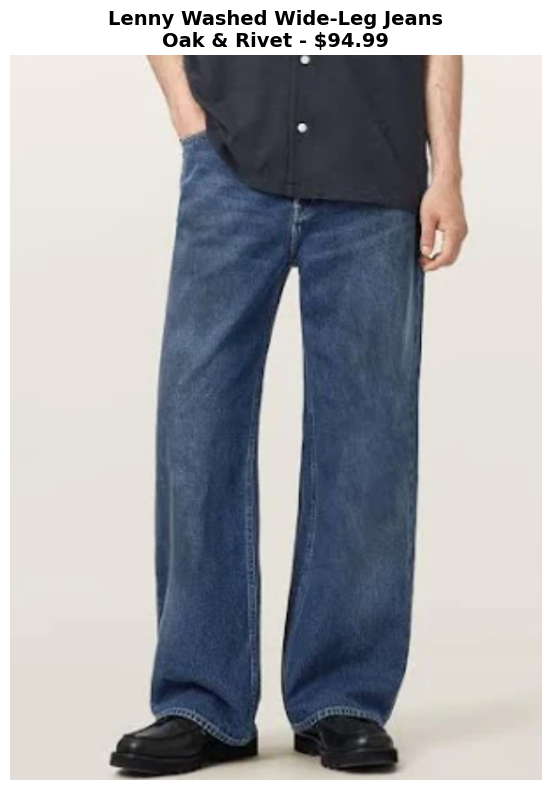


✅ IMAGE DISPLAY SUCCESS!

✅ Complete Image Pipeline Verified:
   1. Image uploaded to Azure Blob Storage ✅
   2. Blob URL stored in Cosmos DB ✅
   3. Image accessible via Managed Identity ✅
   4. Image displayed in notebook ✅

🎉 The complete RAG pipeline is working end-to-end!
   - Vector search finds products (Azure AI Search)
   - Full details retrieved (Cosmos DB)
   - Images accessible (Azure Blob Storage with Managed Identity)
   - Ready for voice agent integration!


✅ IMAGE DISPLAY SUCCESS!

✅ Complete Image Pipeline Verified:
   1. Image uploaded to Azure Blob Storage ✅
   2. Blob URL stored in Cosmos DB ✅
   3. Image accessible via Managed Identity ✅
   4. Image displayed in notebook ✅

🎉 The complete RAG pipeline is working end-to-end!
   - Vector search finds products (Azure AI Search)
   - Full details retrieved (Cosmos DB)
   - Images accessible (Azure Blob Storage with Managed Identity)
   - Ready for voice agent integration!



In [39]:
# Step 9.2: Download and display image from blob storage

if blob_url:
    print(f"\n{'='*80}")
    print(f"📥 DOWNLOADING IMAGE FROM BLOB STORAGE")
    print(f"{'='*80}\n")
    
    try:
        from PIL import Image
        from io import BytesIO
        import matplotlib.pyplot as plt
        from azure.storage.blob import BlobServiceClient
        from azure.identity import DefaultAzureCredential
        
        # Initialize Blob Service Client with Managed Identity (same as notebook 14)
        account_url = f"https://{AZURE_STORAGE_ACCOUNT_NAME}.blob.core.windows.net"
        credential = DefaultAzureCredential()
        blob_service_client = BlobServiceClient(account_url=account_url, credential=credential)
        
        # Extract blob name from URL
        # URL format: https://storagefactoryeastus.blob.core.windows.net/clothesimages/products/PROD-...
        blob_name = blob_url.split(f"/{BLOB_CONTAINER_NAME}/")[-1]
        
        print(f"🌐 Blob Name: {blob_name}")
        print(f"🔐 Using Managed Identity authentication...")
        
        # Get blob client
        blob_client = blob_service_client.get_blob_client(
            container=BLOB_CONTAINER_NAME,
            blob=blob_name
        )
        
        # Download blob using Azure SDK (NOT requests)
        print(f"📥 Downloading from blob storage...")
        blob_data = blob_client.download_blob()
        image_bytes = blob_data.readall()
        
        print(f"✅ Download successful! ({len(image_bytes)} bytes)")
        
        # Open image with PIL
        image_data = BytesIO(image_bytes)
        img = Image.open(image_data)
        
        print(f"\n📊 Image Details:")
        print(f"   Format: {img.format}")
        print(f"   Size: {img.size[0]}x{img.size[1]} pixels")
        print(f"   Mode: {img.mode}")
        
        # Display image in notebook
        print(f"\n🖼️  Displaying image...\n")
        
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{product_doc['name']}\n{product_doc.get('brand', 'Unknown Brand')} - ${product_doc.get('pricing', {}).get('base_price', 0):.2f}", 
                 fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        print(f"\n{'='*80}")
        print(f"✅ IMAGE DISPLAY SUCCESS!")
        print(f"{'='*80}")
        print(f"""
✅ Complete Image Pipeline Verified:
   1. Image uploaded to Azure Blob Storage ✅
   2. Blob URL stored in Cosmos DB ✅
   3. Image accessible via Managed Identity ✅
   4. Image displayed in notebook ✅
   
🎉 The complete RAG pipeline is working end-to-end!
   - Vector search finds products (Azure AI Search)
   - Full details retrieved (Cosmos DB)
   - Images accessible (Azure Blob Storage with Managed Identity)
   - Ready for voice agent integration!
""")
        
    except Exception as e:
        print(f"❌ Error downloading/displaying image: {e}")
        print(f"\n💡 Troubleshooting:")
        print(f"   1. Make sure you're logged in: az login")
        print(f"   2. Verify 'Storage Blob Data Contributor' role")
        print(f"   3. Check blob exists: az storage blob list --account-name {AZURE_STORAGE_ACCOUNT_NAME} --container-name {BLOB_CONTAINER_NAME}")
        print(f"   4. Verify blob name: {blob_name if 'blob_name' in locals() else 'N/A'}")
        print(f"\n📝 Note: Using Managed Identity (same as notebook 14)")
        
else:
    print(f"\n⚠️  No blob URL available to display")
    print(f"   Please run the pipeline first to create and upload a product image")

In [40]:
# Step 9.3: (Optional) Display Multiple Products from Blob Storage

# Set to True to display all products with images
DISPLAY_ALL_PRODUCTS = False
MAX_PRODUCTS_TO_DISPLAY = 5

if DISPLAY_ALL_PRODUCTS:
    print("="*80)
    print(f"📸 DISPLAYING MULTIPLE PRODUCTS FROM BLOB STORAGE")
    print("="*80)
    
    # Query all products from Cosmos DB
    print(f"\n🔍 Querying all products from Cosmos DB...")
    products_manager = get_collection_manager("products")
    all_products = await asyncio.to_thread(
        products_manager.query_documents,
        query={},
        limit=MAX_PRODUCTS_TO_DISPLAY
    )
    
    print(f"✅ Found {len(all_products)} products\n")
    
    if all_products:
        from PIL import Image
        from io import BytesIO
        import matplotlib.pyplot as plt
        from azure.storage.blob import BlobServiceClient
        from azure.identity import DefaultAzureCredential
        
        # Initialize Blob Service Client with Managed Identity (same as notebook 14)
        account_url = f"https://{AZURE_STORAGE_ACCOUNT_NAME}.blob.core.windows.net"
        credential = DefaultAzureCredential()
        blob_service_client = BlobServiceClient(account_url=account_url, credential=credential)
        
        print(f"🔐 Using Managed Identity authentication...\n")
        
        # Create a grid of images
        num_products = min(len(all_products), MAX_PRODUCTS_TO_DISPLAY)
        cols = 2
        rows = (num_products + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 7*rows))
        if rows == 1:
            axes = [axes]
        axes = [ax for row in axes for ax in (row if hasattr(row, '__iter__') else [row])]
        
        for idx, product in enumerate(all_products[:MAX_PRODUCTS_TO_DISPLAY]):
            ax = axes[idx]
            
            blob_url = product.get('image_url', '')
            product_name = product.get('name', 'Unknown Product')
            brand = product.get('brand', 'Unknown Brand')
            price = product.get('pricing', {}).get('base_price', 0)
            
            print(f"📦 Product {idx+1}: {product_name}")
            print(f"   Brand: {brand} | Price: ${price:.2f}")
            
            if blob_url:
                try:
                    # Extract blob name from URL
                    blob_name = blob_url.split(f"/{BLOB_CONTAINER_NAME}/")[-1]
                    
                    # Get blob client
                    blob_client = blob_service_client.get_blob_client(
                        container=BLOB_CONTAINER_NAME,
                        blob=blob_name
                    )
                    
                    # Download blob using Azure SDK (NOT requests)
                    blob_data = blob_client.download_blob()
                    image_bytes = blob_data.readall()
                    
                    # Open image with PIL
                    img = Image.open(BytesIO(image_bytes))
                    ax.imshow(img)
                    ax.set_title(f"{product_name}\n{brand} - ${price:.2f}", 
                               fontsize=10, fontweight='bold')
                    print(f"   ✅ Image loaded successfully ({len(image_bytes)} bytes)")
                    
                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading image', 
                           ha='center', va='center', fontsize=12)
                    print(f"   ❌ Error: {e}")
            else:
                ax.text(0.5, 0.5, 'No image URL', ha='center', va='center', fontsize=12)
                print(f"   ⚠️  No image URL")
            
            ax.axis('off')
            print()
        
        # Hide empty subplots
        for idx in range(num_products, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n{'='*80}")
        print(f"✅ Displayed {num_products} products with images")
        print(f"{'='*80}")
    else:
        print(f"⚠️  No products found in Cosmos DB")
        print(f"   Run the pipeline to create products first")
else:
    print("ℹ️  Skipping multiple product display")
    print("   Set DISPLAY_ALL_PRODUCTS = True to enable")

ℹ️  Skipping multiple product display
   Set DISPLAY_ALL_PRODUCTS = True to enable

   Set DISPLAY_ALL_PRODUCTS = True to enable
